# 🌍 Comprehensive Air Quality Index (AQI) Analysis & Prediction

**Project**: Air Quality Prediction & Analysis using Kaggle Dataset  
**Author**: Data Science Team  
**Date**: 2025-01-23  
**Purpose**: Complete EDA, Feature Engineering, and Multi-Model Comparison for AQI Prediction

---

## 📋 Table of Contents

1. [Project Overview & Setup](#1-project-overview--setup)
2. [Data Loading & Initial Exploration](#2-data-loading--initial-exploration)
3. [Data Quality Assessment](#3-data-quality-assessment)
4. [Comprehensive Exploratory Data Analysis](#4-comprehensive-exploratory-data-analysis)
5. [Advanced Feature Engineering](#5-advanced-feature-engineering)
6. [Multi-Model Comparison & Evaluation](#6-multi-model-comparison--evaluation)
7. [Model Performance Analysis](#7-model-performance-analysis)
8. [Results Visualization & Insights](#8-results-visualization--insights)
9. [Conclusions & Recommendations](#9-conclusions--recommendations)

---

In [2]:
!poetry add statsmodels

Using version ^0.14.5 for statsmodels

Updating dependencies
Resolving dependencies... (0.7s)

Package operations: 12 installs, 0 updates, 0 removals

  - Installing et-xmlfile (2.0.0): Pending...
  - Installing pyjsparser (2.7.1): Pending...
  - Installing tzlocal (5.3.1): Pending...
  - Installing tzlocal (5.3.1): Downloading... 0%
  - Installing tzlocal (5.3.1): Downloading... 0%
  - Installing pyjsparser (2.7.1): Downloading... 0%
  - Installing tzlocal (5.3.1): Downloading... 0%
  - Installing pyjsparser (2.7.1): Downloading... 0%
  - Installing tzlocal (5.3.1): Downloading... 0%
  - Installing et-xmlfile (2.0.0): Downloading... 0%
  - Installing pyjsparser (2.7.1): Downloading... 0%
  - Installing tzlocal (5.3.1): Downloading... 0%
  - Installing tzlocal (5.3.1): Downloading... 100%
  - Installing tzlocal (5.3.1): Installing...
  - Installing pyjsparser (2.7.1): Downloading... 0%
  - Installing tzlocal (5.3.1): Installing...
  - Installing et-xmlfile (2.0.0): Downloading... 100%


## 1. Project Overview & Setup

### 🎯 Objectives
- Analyze air quality patterns across major Indian cities using Kaggle dataset
- Understand relationships between pollutants, weather, and temporal factors
- Compare multiple machine learning models for AQI prediction
- Identify key factors influencing air quality
- Generate comprehensive reports with visualizations

### 📊 Dataset Information
- **Source**: Kaggle Air Quality Dataset - India (2015-2020)
- **Size**: 240,000+ records across multiple cities
- **Time Period**: 5 years (2015-2020)
- **Cities**: Multiple major Indian cities
- **Features**: PM2.5, PM10, NO2, SO2, CO, O3, AQI
- **Target**: Air Quality Index (AQI)

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import warnings
import json
from datetime import datetime, timedelta
from pathlib import Path
import os
import sys

# Add src directory to path for imports
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit

# Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set random seed for reproducibility
np.random.seed(42)

# Create directories for saving plots
FIGURES_DIR = Path('../reports/figures')
REPORTS_DIR = Path('../reports')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Libraries imported successfully")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")
print(f"📈 Matplotlib version: {plt.matplotlib.__version__}")
print(f"🎨 Seaborn version: {sns.__version__}")
print(f"🤖 Scikit-learn version: {sklearn.__version__ if 'sklearn' in globals() else 'Available'}")
print(f"📅 Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
📊 Pandas version: 2.3.1
🔢 NumPy version: 1.26.4
📈 Matplotlib version: 3.10.3
🎨 Seaborn version: 0.12.2
🤖 Scikit-learn version: Available
📅 Analysis started at: 2025-07-23 22:58:00


## 2. Data Loading & Initial Exploration

In [4]:
# Load the processed Kaggle dataset
data_path = '../data/processed/processed_aqi_data.csv'

try:
    df = pd.read_csv(data_path)
    df['datetime'] = pd.to_datetime(df['datetime'])
    print(f"✅ Dataset loaded successfully")
    print(f"📊 Dataset shape: {df.shape}")
    
    # Sort by datetime for time series analysis
    df = df.sort_values(['city', 'datetime']).reset_index(drop=True)
    
except FileNotFoundError:
    print("❌ Processed dataset not found. Loading raw Kaggle data...")
    
    # Load raw Kaggle data
    kaggle_files = [
        ('../data/kaggle_raw/city_hour.csv', 'hourly city data'),
        ('../data/kaggle_raw/station_hour.csv', 'hourly station data'), 
        ('../data/kaggle_raw/city_day.csv', 'daily city data'),
        ('../data/kaggle_raw/station_day.csv', 'daily station data')
    ]
    
    # Try to load the first available file
    df = None
    for filepath, description in kaggle_files:
        try:
            df = pd.read_csv(filepath)
            print(f"📊 Loaded {description}: {len(df):,} records")
            
            # Standardize column names
            column_mapping = {
                'City': 'city', 'Date': 'date', 'Datetime': 'datetime',
                'PM2.5': 'pm25', 'PM10': 'pm10', 'NO': 'no', 'NO2': 'no2',
                'CO': 'co', 'SO2': 'so2', 'O3': 'o3', 'AQI': 'aqi',
                'StationId': 'station_id', 'StationName': 'station_name'
            }
            df = df.rename(columns=column_mapping)
            
            # Handle datetime
            if 'datetime' in df.columns:
                df['datetime'] = pd.to_datetime(df['datetime'])
            elif 'date' in df.columns:
                df['datetime'] = pd.to_datetime(df['date'])
            
            # Add source column
            df['source'] = 'Kaggle_Dataset'
            
            break
        except FileNotFoundError:
            continue
    
    if df is None:
        print("❌ No Kaggle data files found. Creating sample data for demo...")
        # Create sample data
        np.random.seed(42)
        n_samples = 10000
        dates = pd.date_range('2020-01-01', periods=n_samples//4, freq='h')
        cities = ['Delhi', 'Mumbai', 'Bangalore', 'Chennai']
        
        data = []
        for city in cities:
            city_multiplier = {'Delhi': 1.5, 'Mumbai': 1.2, 'Bangalore': 0.8, 'Chennai': 1.0}[city]
            for date in dates:
                data.append({
                    'datetime': date,
                    'city': city,
                    'pm25': max(5, np.random.normal(60 * city_multiplier, 20)),
                    'pm10': max(10, np.random.normal(90 * city_multiplier, 25)),
                    'no2': max(1, np.random.normal(25 * city_multiplier, 8)),
                    'so2': max(1, np.random.normal(10 * city_multiplier, 5)),
                    'co': max(0.1, np.random.normal(1.5 * city_multiplier, 0.5)),
                    'o3': max(1, np.random.normal(35 * city_multiplier, 10)),
                    'aqi': max(10, np.random.normal(120 * city_multiplier, 40)),
                    'source': 'Synthetic_Data'
                })
        
        df = pd.DataFrame(data)
        df['datetime'] = pd.to_datetime(df['datetime'])
        print(f"📝 Created sample dataset: {len(df):,} records")

# Display basic information
print("\n📋 DATASET OVERVIEW")
print("=" * 50)
print(f"📊 Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"📅 Date Range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"🏙️  Cities: {df['city'].nunique()} unique cities")
print(f"🕐 Time Span: {(df['datetime'].max() - df['datetime'].min()).days} days")
print(f"💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n🏙️  CITIES IN DATASET:")
city_counts = df['city'].value_counts()
for city, count in city_counts.items():
    print(f"   {city}: {count:,} records")

✅ Dataset loaded successfully
📊 Dataset shape: (242416, 37)

📋 DATASET OVERVIEW
📊 Shape: 242,416 rows × 37 columns
📅 Date Range: 2015-01-01 01:00:00 to 2020-07-01 00:00:00
🏙️  Cities: 6 unique cities
🕐 Time Span: 2007 days
💾 Memory Usage: 138.06 MB

🏙️  CITIES IN DATASET:
   Delhi: 48,173 records
   Hyderabad: 47,844 records
   Chennai: 47,447 records
   Mumbai: 46,636 records
   Ahmedabad: 32,826 records
   Kolkata: 19,490 records


In [5]:
# Display first few rows and basic statistics
print("👀 FIRST 5 ROWS:")
display(df.head())

print("\n📊 DATA TYPES:")
display(df.dtypes.to_frame('Data Type'))

print("\n📈 BASIC STATISTICS:")
display(df.describe())

👀 FIRST 5 ROWS:


,city,datetime,pm25,pm10,no,no2,nox,nh3,co,so2,o3,benzene,toluene,xylene,aqi,aqi_bucket,source,hour,day_of_week,month,day_of_year,is_weekend,season,is_rush_hour,is_clean_hour,latitude,longitude,state,aqi_category,pm_ratio,aqi_lag_1h,aqi_lag_6h,aqi_lag_12h,aqi_lag_24h,aqi_rolling_6h,aqi_rolling_12h,aqi_rolling_24h
0,Ahmedabad,2015-01-01 01:00:00,48.05,107.66,1.00,40.01,36.37,26.58,1.00,122.07,29.14,0.0,0.0,0.0,131.0,Moderate,Kaggle_Dataset,1,3,1,1,0,Winter,0,0,23.0225,72.5714,Gujarat,Good,0.467303,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,48.05,107.66,0.02,27.75,19.73,26.58,0.02,85.90,29.14,0.0,0.0,0.0,131.0,Moderate,Kaggle_Dataset,2,3,1,1,0,Winter,0,1,23.0225,72.5714,Gujarat,Good,0.467303,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,48.05,107.66,0.08,19.32,11.08,26.58,0.08,52.83,29.14,0.0,0.0,0.0,131.0,Moderate,Kaggle_Dataset,3,3,1,1,0,Winter,0,1,23.0225,72.5714,Gujarat,Good,0.467303,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,48.05,107.66,0.30,16.45,9.20,26.58,0.30,39.53,153.58,0.0,0.0,0.0,131.0,Moderate,Kaggle_Dataset,4,3,1,1,0,Winter,0,1,23.0225,72.5714,Gujarat,Good,0.467303,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,48.05,107.66,0.12,14.90,7.85,26.58,0.12,32.63,153.58,0.0,0.0,0.0,131.0,Moderate,Kaggle_Dataset,5,3,1,1,0,Winter,0,1,23.0225,72.5714,Gujarat,Good,0.467303,NaN,NaN,NaN,NaN,NaN,NaN,NaN



📊 DATA TYPES:


,Data Type
city,object
datetime,datetime64[ns]
pm25,float64
pm10,float64
no,float64
no2,float64
nox,float64
nh3,float64
co,float64
so2,float64



📈 BASIC STATISTICS:


,datetime,pm25,pm10,no,no2,nox,nh3,co,so2,o3,benzene,toluene,xylene,aqi,hour,day_of_week,month,day_of_year,is_weekend,is_rush_hour,is_clean_hour,latitude,longitude,pm_ratio,aqi_lag_1h,aqi_lag_6h,aqi_lag_12h,aqi_lag_24h,aqi_rolling_6h,aqi_rolling_12h,aqi_rolling_24h
count,242416,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,242416.000000,209698.000000,209668.000000,209632.000000,209560.000000,209704.000000,209704.000000,209704.000000
mean,2017-12-10 14:38:39.634017536,64.205609,128.046011,20.354038,34.718934,47.475468,34.677496,3.669973,17.569658,37.006609,3.475108,10.834360,1.315829,188.860286,11.516034,2.996667,6.271397,175.449995,0.284783,0.291635,0.166144,20.280118,77.496025,0.745116,197.889465,197.906624,197.926581,197.968505,197.894245,197.601319,197.575172
min,2015-01-01 01:00:00,0.010000,0.010000,0.010000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,13.082700,72.571400,0.000991,18.000000,18.000000,18.000000,18.000000,18.000000,20.500000,22.222222
25%,2016-07-21 09:00:00,31.000000,92.500000,4.980000,15.260000,15.170000,18.470000,0.330000,5.530000,17.830000,0.040000,0.260000,0.040000,89.000000,6.000000,1.000000,3.000000,86.000000,0.000000,0.000000,0.000000,17.385000,72.877700,0.429220,82.000000,82.000000,82.000000,82.000000,83.500000,84.500000,86.625000
50%,2018-02-24 11:00:00,48.050000,107.660000,8.780000,25.070000,25.570000,26.580000,0.780000,9.460000,29.140000,1.090000,3.230000,0.200000,131.000000,12.000000,3.000000,6.000000,169.000000,0.000000,0.000000,0.000000,19.076000,77.209000,0.467303,131.000000,131.000000,131.000000,131.000000,131.166667,131.500000,131.375000
75%,2019-05-04 20:00:00,71.880000,126.420000,17.310000,42.410000,51.670000,35.910000,1.480000,16.562500,48.220000,3.360000,12.860000,0.680000,216.000000,18.000000,5.000000,9.000000,265.000000,1.000000,1.000000,0.000000,23.022500,80.270700,0.505427,243.000000,243.000000,243.000000,244.000000,245.833333,248.833333,250.666667
max,2020-07-01 00:00:00,686.930000,784.750000,498.970000,309.320000,498.610000,499.970000,270.330000,188.600000,199.280000,391.880000,488.530000,461.390000,2722.000000,23.000000,6.000000,12.000000,366.000000,1.000000,1.000000,1.000000,28.613900,88.363900,2676.732327,2722.000000,2722.000000,2722.000000,2722.000000,2722.000000,2636.000000,2319.222222
std,NaN,62.522829,91.959500,37.595540,32.307760,56.642304,35.147686,14.717349,26.507287,28.864617,12.557398,20.334435,5.560268,207.260740,6.924099,1.998675,3.422669,104.573091,0.451312,0.454516,0.372211,5.226362,4.312800,14.440307,221.484149,221.495101,221.508485,221.534128,211.452222,196.080592,179.672652


## 3. Data Quality Assessment

❓ MISSING VALUES ANALYSIS


,Missing Count,Missing Percentage
aqi_lag_24h,32856,13.553561
aqi_lag_12h,32784,13.523860
aqi_lag_6h,32748,13.509009
aqi_lag_1h,32718,13.496634
aqi_rolling_6h,32712,13.494159
aqi_rolling_12h,32712,13.494159
aqi_rolling_24h,32712,13.494159


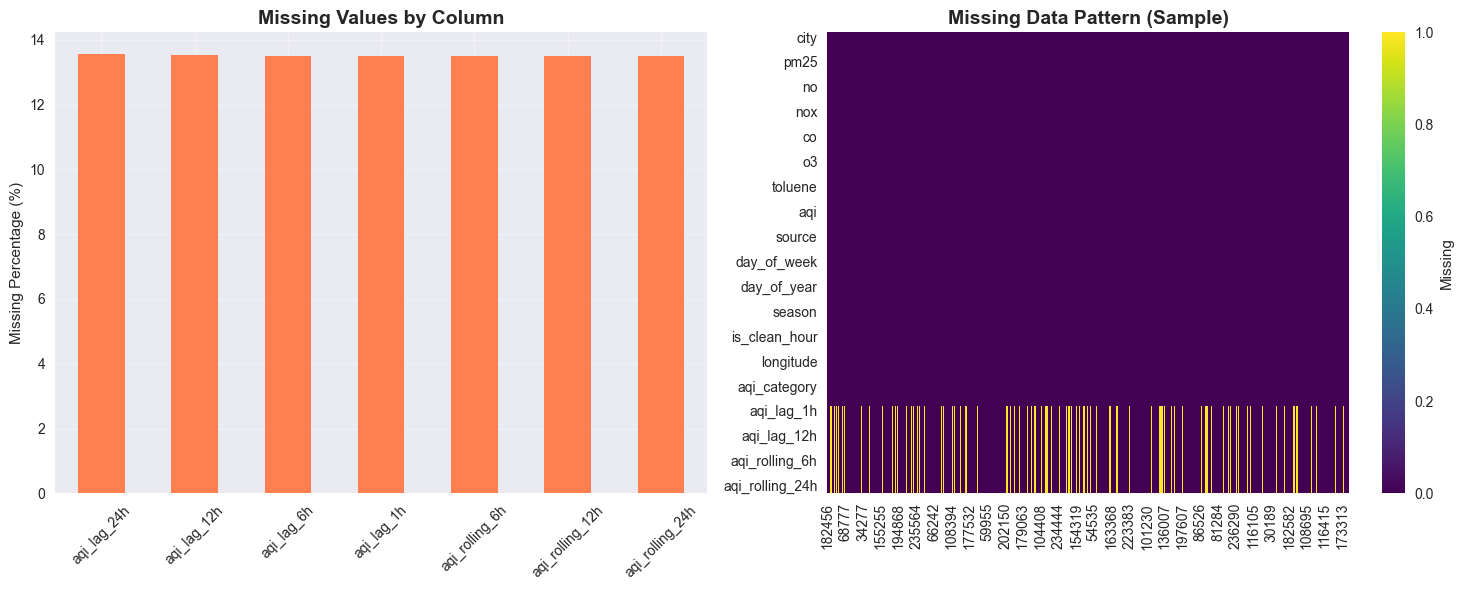


📊 DATA TYPES AND UNIQUE VALUES:


,Data Type,Unique Values,Memory Usage (MB)
Index,NaN,NaN,0.000126
aqi,float64,1498.0,1.849487
aqi_bucket,object,6.0,13.258245
aqi_category,object,6.0,13.813712
aqi_lag_12h,float64,1498.0,1.849487
aqi_lag_1h,float64,1498.0,1.849487
aqi_lag_24h,float64,1498.0,1.849487
aqi_lag_6h,float64,1498.0,1.849487
aqi_rolling_12h,float64,12778.0,1.849487
aqi_rolling_24h,float64,22448.0,1.849487


In [6]:
# Comprehensive data quality assessment
print("❓ MISSING VALUES ANALYSIS")
print("=" * 50)

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    display(missing_df)
    
    # Visualize missing data
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Missing values bar plot
    missing_df['Missing Percentage'].plot(kind='bar', ax=axes[0], color='coral')
    axes[0].set_title('Missing Values by Column', size=14, weight='bold')
    axes[0].set_ylabel('Missing Percentage (%)')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Missing values heatmap
    missing_matrix = df.isnull().astype(int)
    if missing_matrix.sum().sum() > 0:
        sns.heatmap(missing_matrix.sample(min(1000, len(df))).T, 
                   cmap='viridis', cbar_kws={'label': 'Missing'}, ax=axes[1])
        axes[1].set_title('Missing Data Pattern (Sample)', size=14, weight='bold')
    else:
        axes[1].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', 
                    transform=axes[1].transAxes, fontsize=16)
        axes[1].set_title('Missing Data Pattern', size=14, weight='bold')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'missing_values_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("✅ No missing values found in the dataset!")

# Data types and unique values
print("\n📊 DATA TYPES AND UNIQUE VALUES:")
print("=" * 50)
data_info = pd.DataFrame({
    'Data Type': df.dtypes,
    'Unique Values': df.nunique(),
    'Memory Usage (MB)': df.memory_usage(deep=True) / 1024**2
})
display(data_info)

🔄 DUPLICATE ANALYSIS:
Total duplicates: 0 (0.00%)
Datetime-City duplicates: 0

🚨 OUTLIER DETECTION:


,Column,Q1,Q3,IQR,Lower Bound,Upper Bound,Outliers,Outlier %
0,pm25,31.00,71.88,40.88,-30.32,133.20,21707,8.95
1,pm10,92.50,126.42,33.92,41.62,177.30,58482,24.12
2,no,4.98,17.31,12.33,-13.51,35.80,30206,12.46
3,no2,15.26,42.41,27.15,-25.46,83.14,16780,6.92
4,nox,15.17,51.67,36.50,-39.58,106.42,28800,11.88
5,nh3,18.47,35.91,17.44,-7.69,62.07,28669,11.83
6,co,0.33,1.48,1.15,-1.39,3.20,35479,14.64
7,so2,5.53,16.56,11.03,-11.02,33.11,26009,10.73
8,o3,17.83,48.22,30.39,-27.76,93.80,12650,5.22
9,benzene,0.04,3.36,3.32,-4.94,8.34,20793,8.58


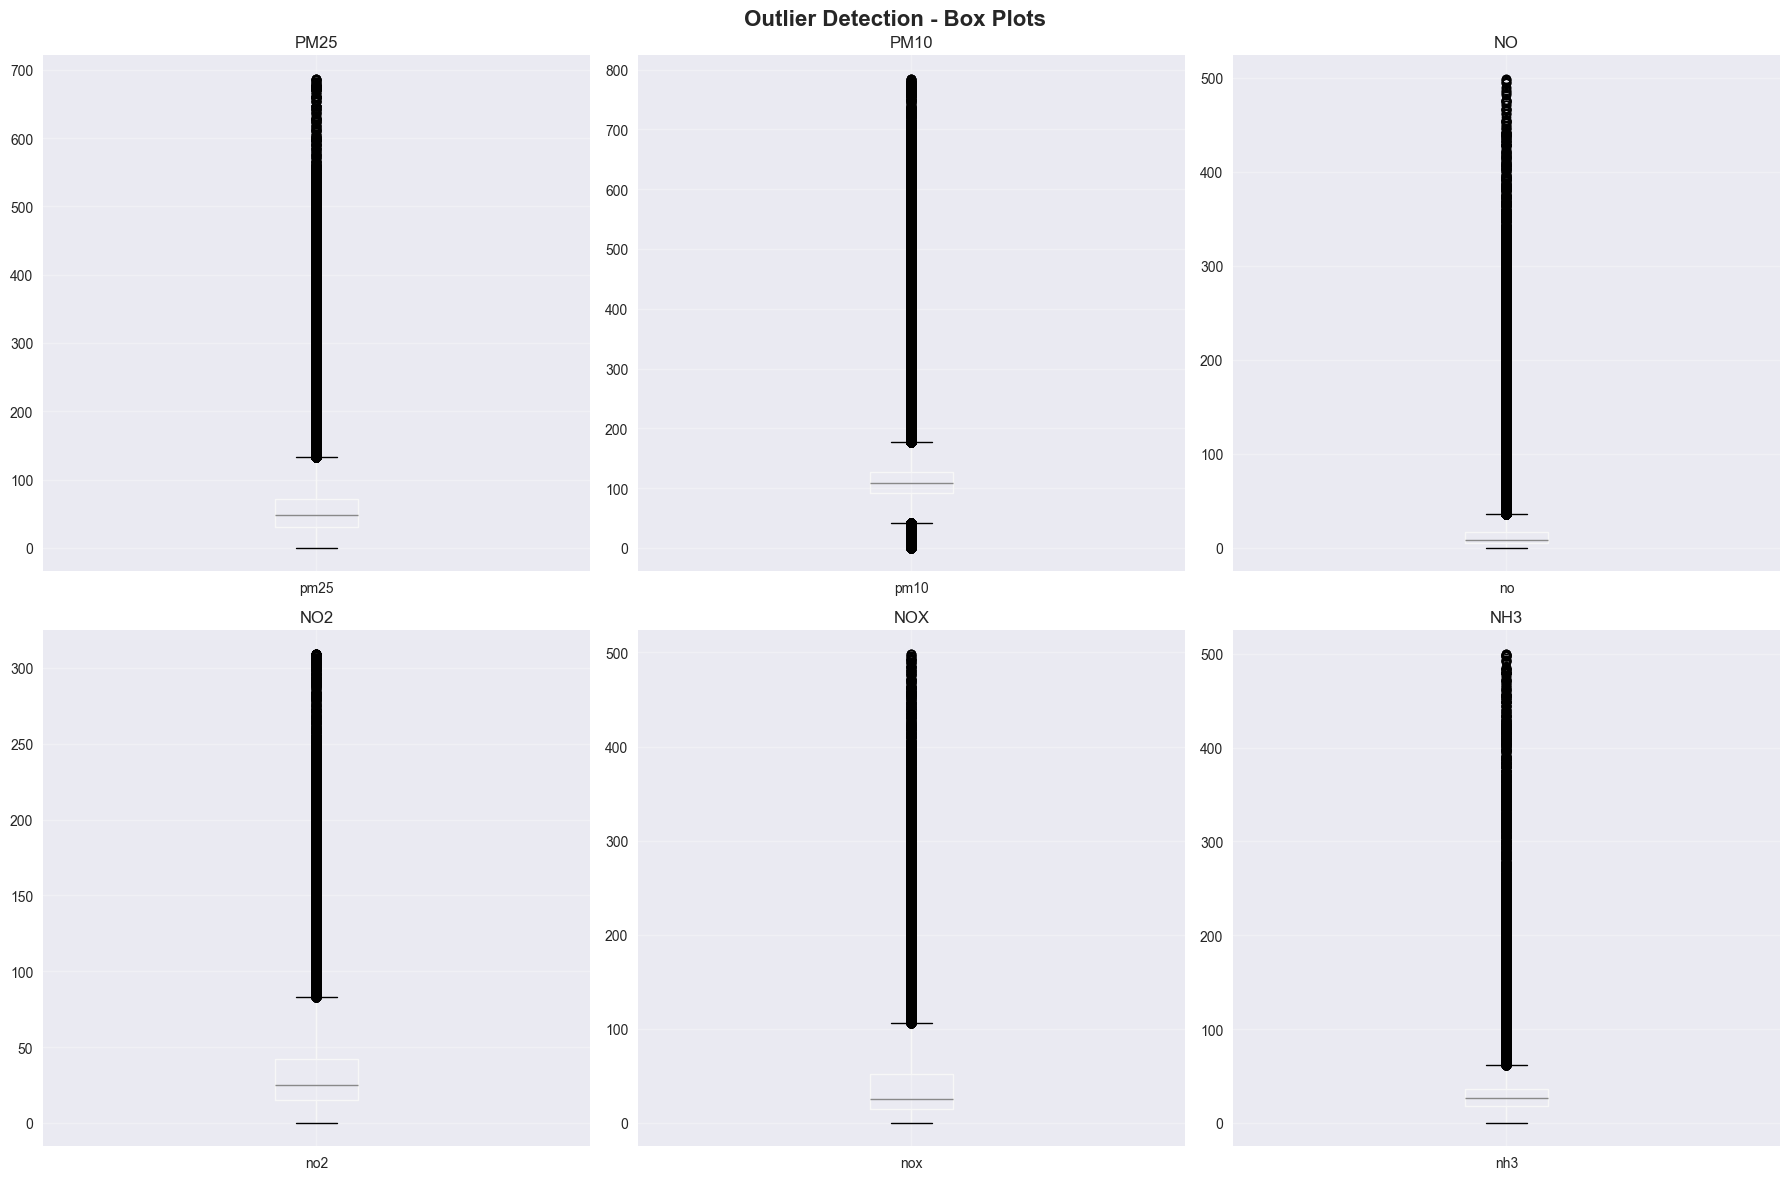

In [7]:
# Check for duplicates and outliers
print("🔄 DUPLICATE ANALYSIS:")
print("=" * 30)
duplicates = df.duplicated().sum()
print(f"Total duplicates: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

# Duplicate analysis by key columns
if 'datetime' in df.columns and 'city' in df.columns:
    datetime_city_duplicates = df.duplicated(subset=['datetime', 'city']).sum()
    print(f"Datetime-City duplicates: {datetime_city_duplicates:,}")

print("\n🚨 OUTLIER DETECTION:")
print("=" * 30)

# Define numeric columns for outlier analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['latitude', 'longitude', 'hour', 'day_of_week', 'month']
pollutant_cols = [col for col in numeric_cols if col not in exclude_cols]

outlier_summary = []
for col in pollutant_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_pct = len(outliers) / len(df) * 100
        
        outlier_summary.append({
            'Column': col,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outliers': len(outliers),
            'Outlier %': outlier_pct
        })

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df.round(2))

# Visualize outliers
if len(pollutant_cols) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Outlier Detection - Box Plots', fontsize=16, fontweight='bold')
    
    for i, col in enumerate(pollutant_cols[:6]):
        row, col_idx = i // 3, i % 3
        if col in df.columns:
            df.boxplot(column=col, ax=axes[row, col_idx])
            axes[row, col_idx].set_title(f'{col.upper()}')
            axes[row, col_idx].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(len(pollutant_cols), 6):
        row, col_idx = i // 3, i % 3
        axes[row, col_idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'outlier_detection_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. Comprehensive Exploratory Data Analysis

### 4.1 AQI Distribution Analysis

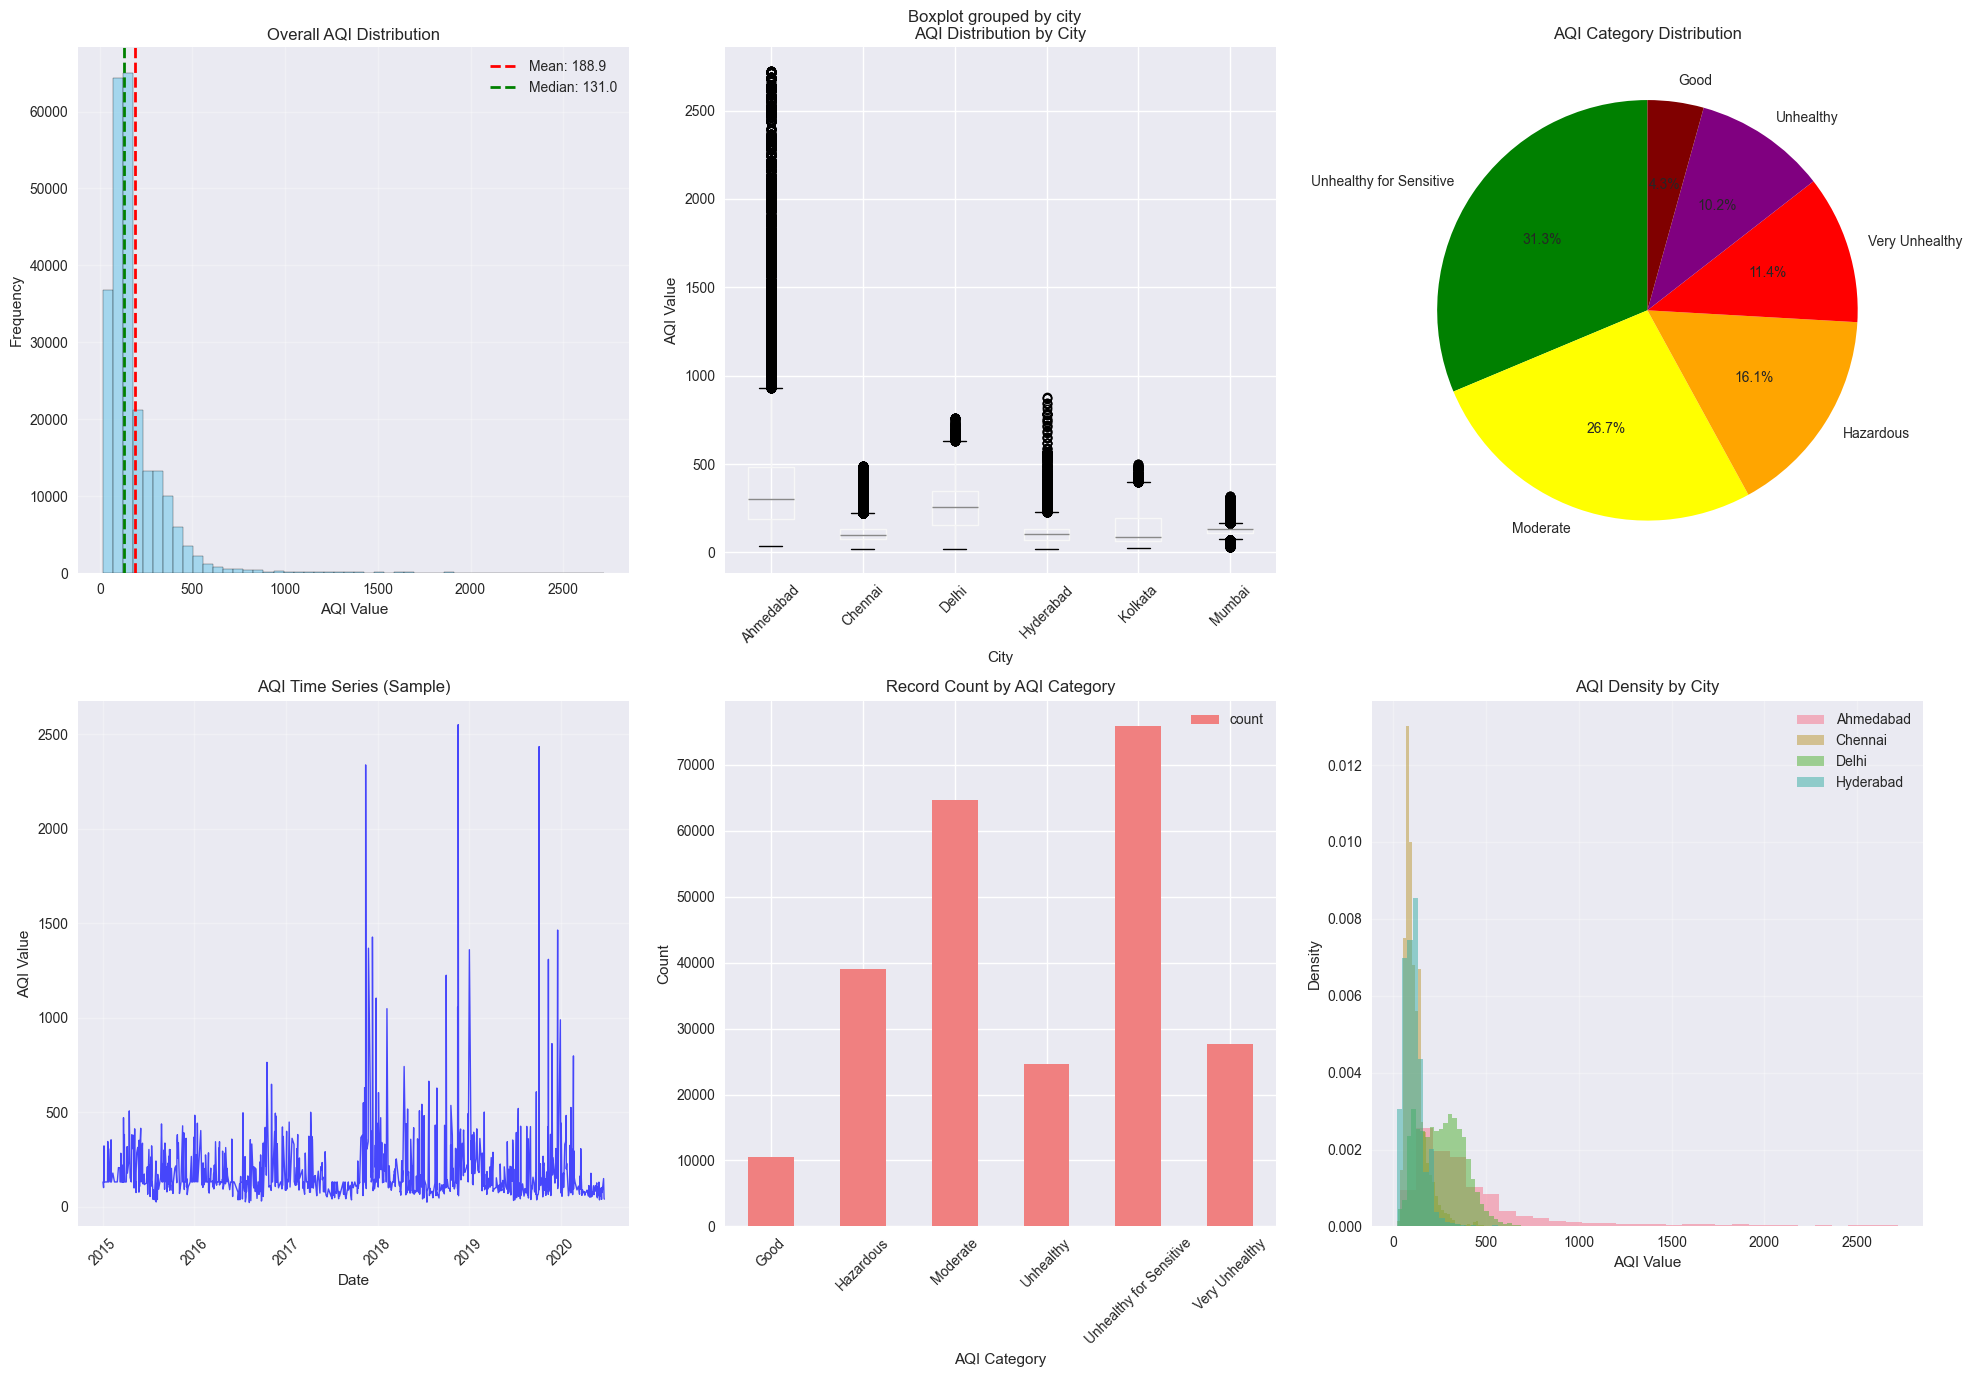

📊 AQI CATEGORY STATISTICS:


,count,mean,std
aqi_category,,,
Good,10455,41.45,6.49
Hazardous,39098,505.55,357.78
Moderate,64622,76.17,13.50
Unhealthy,24658,174.82,14.98
Unhealthy for Sensitive,75910,126.26,11.61
Very Unhealthy,27673,244.52,29.35


In [8]:
# AQI Category definitions
def get_aqi_category(aqi):
    """Categorize AQI values according to standard ranges."""
    if pd.isna(aqi):
        return 'Unknown'
    elif aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

# Apply AQI categorization
if 'aqi' in df.columns:
    df['aqi_category'] = df['aqi'].apply(get_aqi_category)
    
    # Comprehensive AQI analysis
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    fig.suptitle('🌍 Comprehensive Air Quality Index (AQI) Analysis', size=18, weight='bold')
    
    # 1. Overall AQI distribution
    axes[0, 0].hist(df['aqi'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    mean_aqi = df['aqi'].mean()
    median_aqi = df['aqi'].median()
    axes[0, 0].axvline(mean_aqi, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_aqi:.1f}')
    axes[0, 0].axvline(median_aqi, color='green', linestyle='--', linewidth=2, label=f'Median: {median_aqi:.1f}')
    axes[0, 0].set_title('Overall AQI Distribution')
    axes[0, 0].set_xlabel('AQI Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. AQI by city (violin plot)
    if df['city'].nunique() > 1:
        df.boxplot(column='aqi', by='city', ax=axes[0, 1])
        axes[0, 1].set_title('AQI Distribution by City')
        axes[0, 1].set_xlabel('City')
        axes[0, 1].set_ylabel('AQI Value')
        plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45)
    
    # 3. AQI categories pie chart
    aqi_counts = df['aqi_category'].value_counts()
    colors = ['green', 'yellow', 'orange', 'red', 'purple', 'maroon', 'gray']
    axes[0, 2].pie(aqi_counts.values, labels=aqi_counts.index, autopct='%1.1f%%', 
                   colors=colors[:len(aqi_counts)], startangle=90)
    axes[0, 2].set_title('AQI Category Distribution')
    
    # 4. Time series plot (sample)
    sample_data = df.sample(min(1000, len(df))).sort_values('datetime')
    axes[1, 0].plot(sample_data['datetime'], sample_data['aqi'], linewidth=1, alpha=0.7, color='blue')
    axes[1, 0].set_title('AQI Time Series (Sample)')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('AQI Value')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. AQI statistics by category
    category_stats = df.groupby('aqi_category')['aqi'].agg(['count', 'mean', 'std']).round(2)
    category_stats.plot(kind='bar', ax=axes[1, 1], y='count', color='lightcoral')
    axes[1, 1].set_title('Record Count by AQI Category')
    axes[1, 1].set_xlabel('AQI Category')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    # 6. AQI density plot by city
    for city in df['city'].unique()[:4]:  # Top 4 cities
        city_data = df[df['city'] == city]['aqi'].dropna()
        if len(city_data) > 0:
            axes[1, 2].hist(city_data, alpha=0.5, label=city, bins=30, density=True)
    axes[1, 2].set_title('AQI Density by City')
    axes[1, 2].set_xlabel('AQI Value')
    axes[1, 2].set_ylabel('Density')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'comprehensive_aqi_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display category statistics
    print("📊 AQI CATEGORY STATISTICS:")
    display(category_stats)
else:
    print("⚠️ AQI column not found in dataset")

### 4.2 Pollutant Analysis

📊 Available Pollutant Parameters: ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']


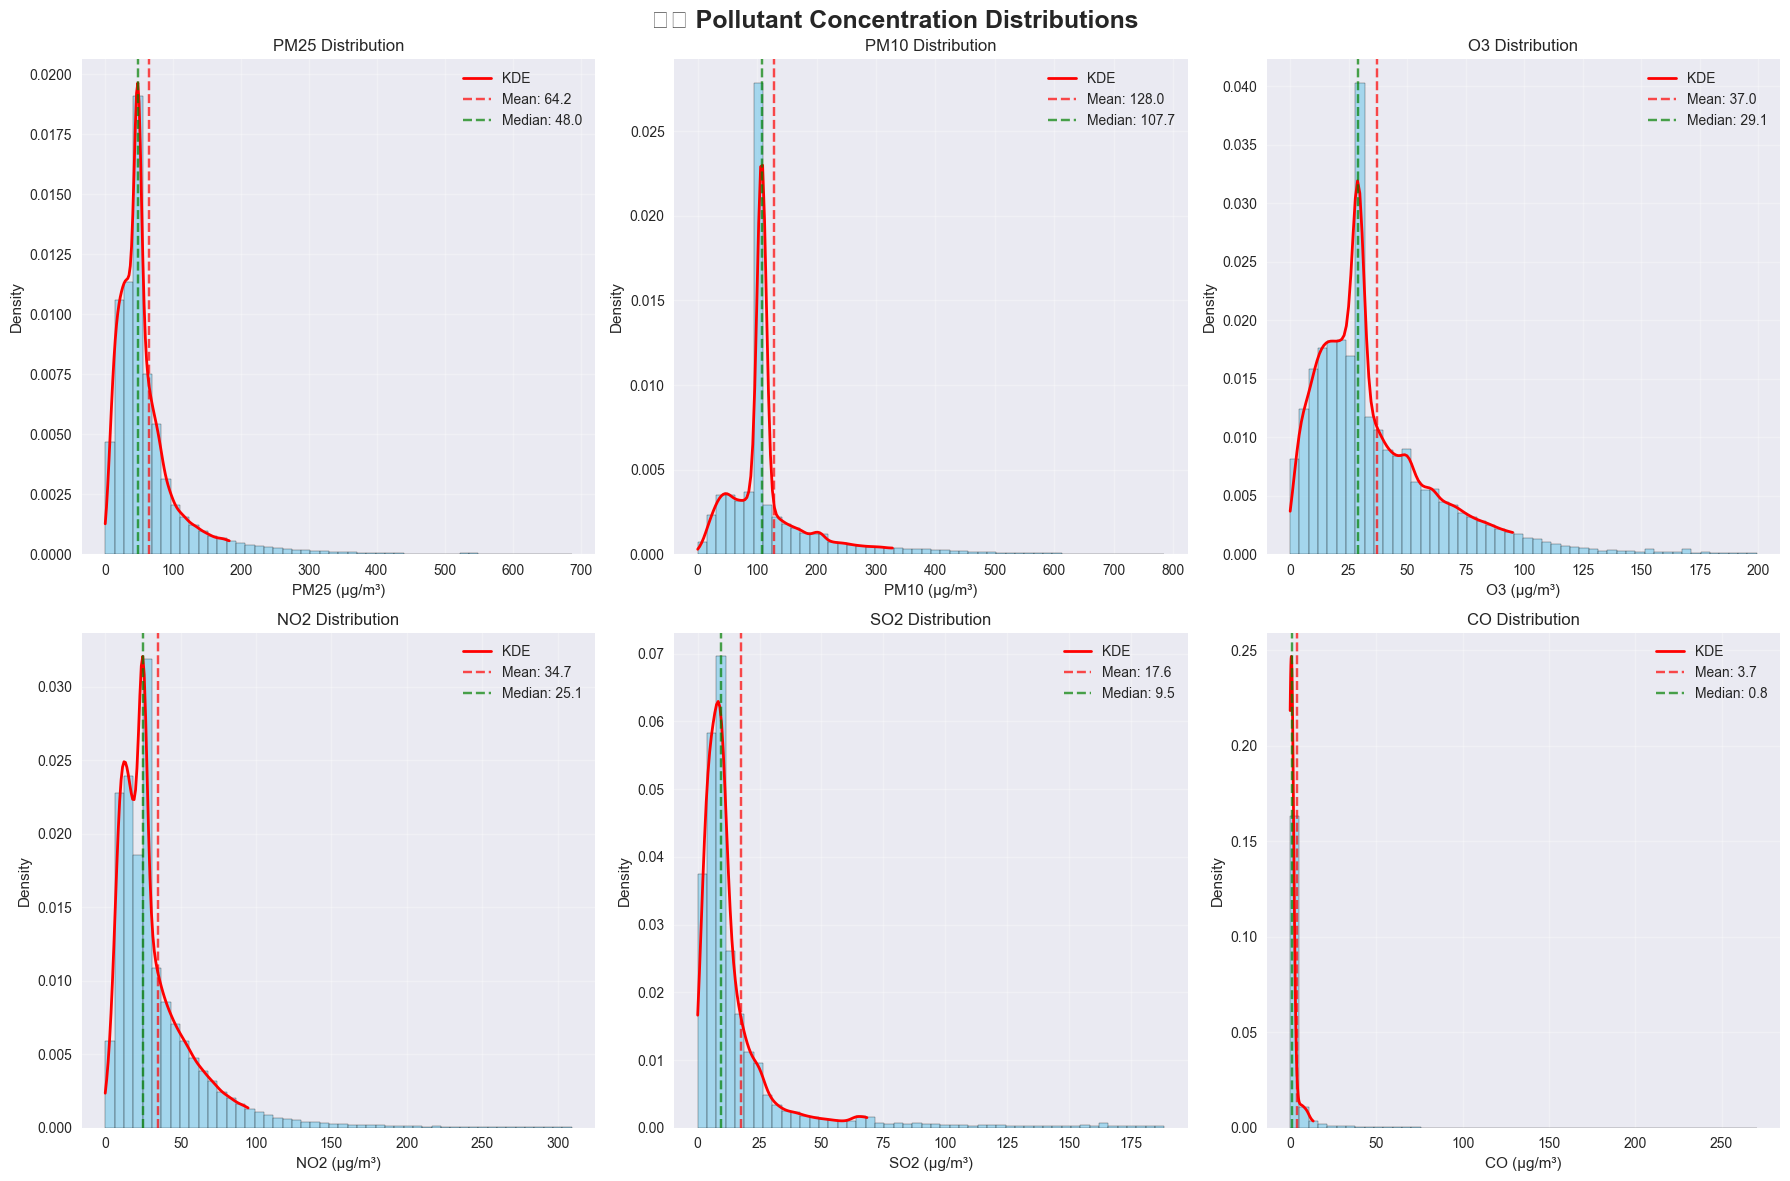


📊 POLLUTANT STATISTICS:


,count,mean,std,min,25%,50%,75%,max,cv
pm25,242416.0,64.21,62.52,0.01,31.00,48.05,71.88,686.93,97.38
pm10,242416.0,128.05,91.96,0.01,92.50,107.66,126.42,784.75,71.82
o3,242416.0,37.01,28.86,0.01,17.83,29.14,48.22,199.28,78.00
no2,242416.0,34.72,32.31,0.01,15.26,25.07,42.41,309.32,93.06
so2,242416.0,17.57,26.51,0.01,5.53,9.46,16.56,188.60,150.87
co,242416.0,3.67,14.72,0.00,0.33,0.78,1.48,270.33,401.02


In [9]:
# Define available pollutant parameters
pollutant_params = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
available_params = [param for param in pollutant_params if param in df.columns]

print(f"📊 Available Pollutant Parameters: {available_params}")

if available_params:
    # Distribution plots for all pollutants
    n_cols = 3
    n_rows = (len(available_params) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    fig.suptitle('🌫️ Pollutant Concentration Distributions', fontsize=18, fontweight='bold')
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, param in enumerate(available_params):
        row, col = i // n_cols, i % n_cols
        
        # Histogram with KDE
        data = df[param].dropna()
        if len(data) > 0:
            axes[row, col].hist(data, bins=50, alpha=0.7, density=True, color='skyblue', edgecolor='black')
            
            # Add KDE
            try:
                from scipy.stats import gaussian_kde
                kde = gaussian_kde(data)
                x_range = np.linspace(data.min(), data.quantile(0.95), 100)
                axes[row, col].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
            except:
                pass
            
            # Add statistics
            mean_val = data.mean()
            median_val = data.median()
            axes[row, col].axvline(mean_val, color='red', linestyle='--', alpha=0.7, 
                                  label=f'Mean: {mean_val:.1f}')
            axes[row, col].axvline(median_val, color='green', linestyle='--', alpha=0.7, 
                                  label=f'Median: {median_val:.1f}')
            
            axes[row, col].set_title(f'{param.upper()} Distribution')
            axes[row, col].set_xlabel(f'{param.upper()} (µg/m³)')
            axes[row, col].set_ylabel('Density')
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(len(available_params), n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'pollutant_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Pollutant statistics table
    pollutant_stats = df[available_params].describe().T
    pollutant_stats['cv'] = (pollutant_stats['std'] / pollutant_stats['mean']) * 100  # Coefficient of variation
    
    print("\n📊 POLLUTANT STATISTICS:")
    display(pollutant_stats.round(2))

### 4.3 City-wise Analysis

🏙️ Cities in Analysis: ['Ahmedabad', 'Chennai', 'Delhi', 'Hyderabad', 'Kolkata', 'Mumbai']

🏙️ CITY-WISE POLLUTANT STATISTICS:


,pm25_count,pm25_mean,pm25_median,pm25_std,pm25_min,pm25_max,pm10_count,pm10_mean,pm10_median,pm10_std,pm10_min,pm10_max,o3_count,o3_mean,o3_median,o3_std,o3_min,o3_max,no2_count,no2_mean,no2_median,no2_std,no2_min,no2_max,so2_count,so2_mean,so2_median,so2_std,so2_min,so2_max,co_count,co_mean,co_median,co_std,co_min,co_max,aqi_count,aqi_mean,aqi_median,aqi_std,aqi_min,aqi_max
city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ahmedabad,32826,67.52,52.89,54.98,0.34,678.26,32826,109.98,107.66,34.46,5.65,681.16,32826,40.19,23.60,41.01,0.02,199.28,32826,58.20,39.71,56.28,0.01,309.32,32826,55.09,38.59,49.57,0.01,188.60,32826,20.50,8.58,35.33,0.01,270.33,32826,434.53,305.0,430.00,34.0,2722.0
Chennai,47447,50.01,43.84,39.35,0.02,677.25,47447,101.75,107.66,34.23,0.01,760.25,47447,32.65,27.07,24.37,0.01,198.37,47447,16.88,14.84,12.08,0.05,232.56,47447,7.84,6.04,7.20,0.03,141.26,47447,1.07,0.80,2.08,0.00,46.80,47447,115.58,99.0,58.92,21.0,490.0
Delhi,48173,116.91,86.93,93.94,0.05,686.93,48173,232.57,207.25,138.38,2.99,784.75,48173,50.86,43.32,31.63,0.06,198.79,48173,50.75,44.30,28.03,2.66,295.84,48173,16.10,13.63,10.16,0.02,187.05,48173,1.98,1.10,2.94,0.00,47.42,48173,258.57,256.0,122.19,22.0,762.0
Hyderabad,47844,44.77,40.00,37.81,0.10,558.00,47844,93.24,95.75,43.73,1.00,547.75,47844,33.43,27.30,23.40,0.01,193.05,47844,28.20,23.58,20.16,0.15,244.65,47844,9.01,5.66,12.97,0.02,187.85,47844,0.59,0.43,1.04,0.00,33.80,47844,110.68,103.0,59.66,18.0,877.0
Kolkata,19490,61.52,38.18,63.97,0.02,686.10,19490,110.55,70.48,100.96,0.75,747.22,19490,31.92,23.19,26.82,0.02,170.42,19490,39.37,27.85,35.56,0.16,288.58,19490,11.86,6.55,16.34,0.07,131.19,19490,0.80,0.57,0.68,0.00,6.27,19490,135.79,86.0,102.87,23.0,500.0
Mumbai,46636,42.94,48.05,20.02,0.01,638.74,46636,102.57,107.66,41.09,0.01,776.93,46636,30.68,29.14,18.94,0.55,185.86,46636,24.54,25.07,12.56,0.16,230.31,46636,13.75,9.46,16.92,0.04,164.37,46636,0.57,0.00,0.83,0.00,7.13,46636,120.87,131.0,32.96,29.0,317.0


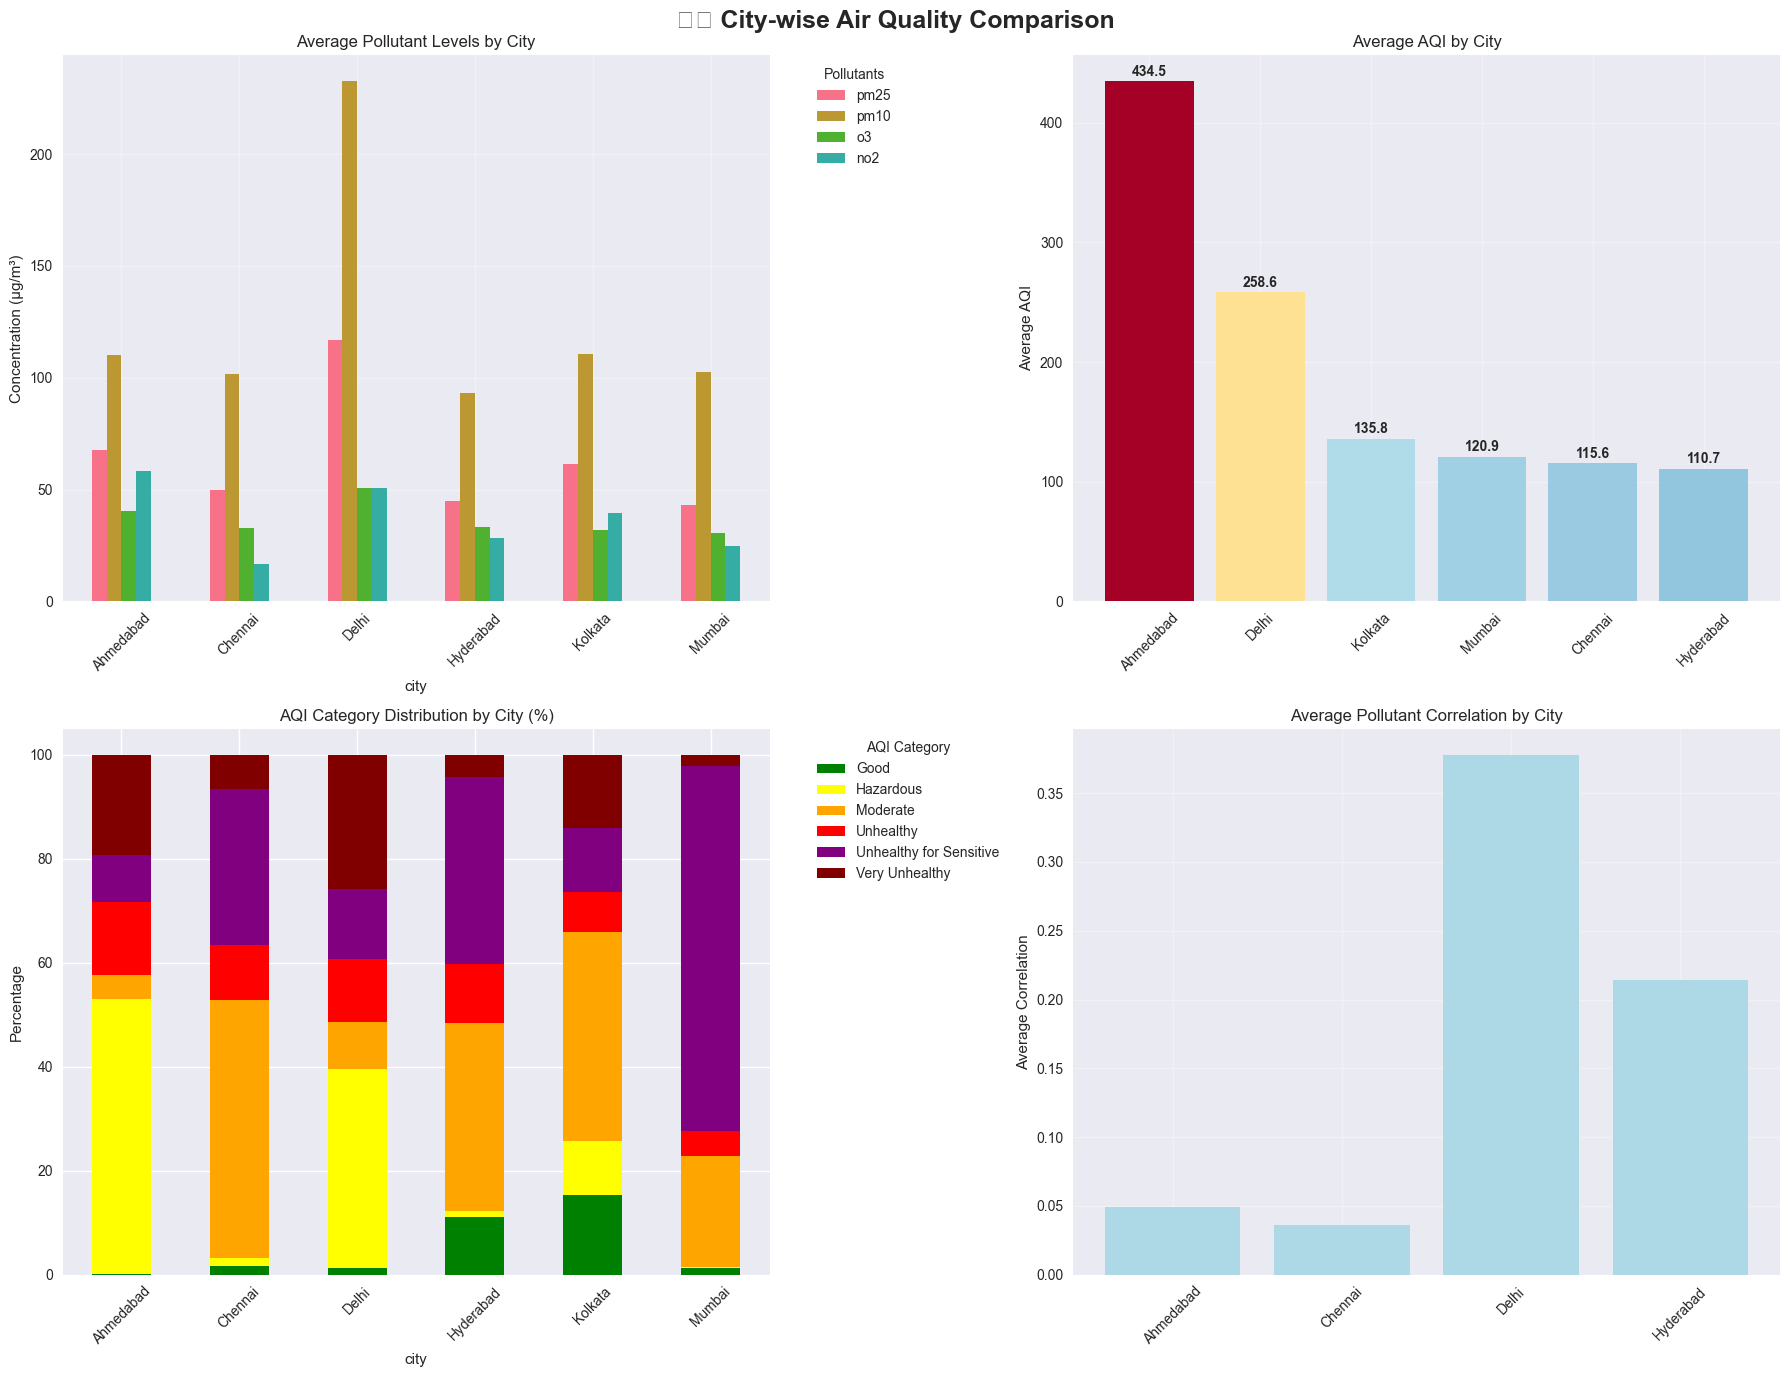


🏆 CITY RANKINGS:

📊 Cities by Average AQI (Best to Worst):
   1. Hyderabad: 110.7 AQI
   2. Chennai: 115.6 AQI
   3. Mumbai: 120.9 AQI
   4. Kolkata: 135.8 AQI
   5. Delhi: 258.6 AQI
   6. Ahmedabad: 434.5 AQI

📊 Cities by Average PM25 (Lowest to Highest):
   1. Mumbai: 42.9 µg/m³
   2. Hyderabad: 44.8 µg/m³
   3. Chennai: 50.0 µg/m³
   4. Kolkata: 61.5 µg/m³
   5. Ahmedabad: 67.5 µg/m³
   6. Delhi: 116.9 µg/m³

📊 Cities by Average PM10 (Lowest to Highest):
   1. Hyderabad: 93.2 µg/m³
   2. Chennai: 101.7 µg/m³
   3. Mumbai: 102.6 µg/m³
   4. Ahmedabad: 110.0 µg/m³
   5. Kolkata: 110.6 µg/m³
   6. Delhi: 232.6 µg/m³

📊 Cities by Average O3 (Lowest to Highest):
   1. Mumbai: 30.7 µg/m³
   2. Kolkata: 31.9 µg/m³
   3. Chennai: 32.7 µg/m³
   4. Hyderabad: 33.4 µg/m³
   5. Ahmedabad: 40.2 µg/m³
   6. Delhi: 50.9 µg/m³


In [10]:
# Comprehensive city-wise analysis
cities = df['city'].unique()
print(f"🏙️ Cities in Analysis: {list(cities)}")

if len(cities) > 1 and available_params:
    # City-wise statistics
    print("\n🏙️ CITY-WISE POLLUTANT STATISTICS:")
    print("=" * 60)
    
    city_stats = df.groupby('city')[available_params + (['aqi'] if 'aqi' in df.columns else [])].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    
    # Flatten column names
    city_stats.columns = [f'{col[0]}_{col[1]}' for col in city_stats.columns]
    display(city_stats)
    
    # City comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('🏙️ City-wise Air Quality Comparison', fontsize=18, fontweight='bold')
    
    # 1. Average pollutant levels by city
    city_means = df.groupby('city')[available_params[:4]].mean()
    city_means.plot(kind='bar', ax=axes[0, 0], rot=45)
    axes[0, 0].set_title('Average Pollutant Levels by City')
    axes[0, 0].set_ylabel('Concentration (µg/m³)')
    axes[0, 0].legend(title='Pollutants', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. AQI comparison (if available)
    if 'aqi' in df.columns:
        aqi_by_city = df.groupby('city')['aqi'].mean().sort_values(ascending=False)
        bars = axes[0, 1].bar(aqi_by_city.index, aqi_by_city.values, 
                             color=plt.cm.RdYlBu_r(aqi_by_city.values/aqi_by_city.max()))
        axes[0, 1].set_title('Average AQI by City')
        axes[0, 1].set_ylabel('Average AQI')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar, value in zip(bars, aqi_by_city.values):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                           f'{value:.1f}', ha='center', va='bottom', weight='bold')
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. AQI category distribution by city
    if 'aqi_category' in df.columns:
        city_category = pd.crosstab(df['city'], df['aqi_category'], normalize='index') * 100
        city_category.plot(kind='bar', stacked=True, ax=axes[1, 0], 
                          color=['green', 'yellow', 'orange', 'red', 'purple', 'maroon', 'gray'])
        axes[1, 0].set_title('AQI Category Distribution by City (%)')
        axes[1, 0].set_ylabel('Percentage')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].legend(title='AQI Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 4. Pollutant correlation by city
    if len(available_params) >= 3:
        # Calculate average correlation across cities
        city_correlations = []
        for city in cities[:4]:  # Top 4 cities
            city_data = df[df['city'] == city][available_params[:3]]
            if len(city_data) > 10:
                corr_matrix = city_data.corr()
                # Get upper triangle correlations
                upper_triangle = np.triu(corr_matrix, k=1)
                correlations = upper_triangle[upper_triangle != 0]
                city_correlations.append(correlations.mean())
            else:
                city_correlations.append(0)
        
        axes[1, 1].bar(cities[:len(city_correlations)], city_correlations, color='lightblue')
        axes[1, 1].set_title('Average Pollutant Correlation by City')
        axes[1, 1].set_ylabel('Average Correlation')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'city_wise_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # City ranking
    print("\n🏆 CITY RANKINGS:")
    print("=" * 40)
    
    if 'aqi' in df.columns:
        aqi_ranking = df.groupby('city')['aqi'].mean().sort_values(ascending=True)
        print("\n📊 Cities by Average AQI (Best to Worst):")
        for i, (city, aqi) in enumerate(aqi_ranking.items(), 1):
            print(f"   {i}. {city}: {aqi:.1f} AQI")
    
    for param in available_params[:3]:
        param_ranking = df.groupby('city')[param].mean().sort_values(ascending=True)
        print(f"\n📊 Cities by Average {param.upper()} (Lowest to Highest):")
        for i, (city, value) in enumerate(param_ranking.items(), 1):
            print(f"   {i}. {city}: {value:.1f} µg/m³")

### 4.4 Temporal Analysis

🕐 TEMPORAL ANALYSIS


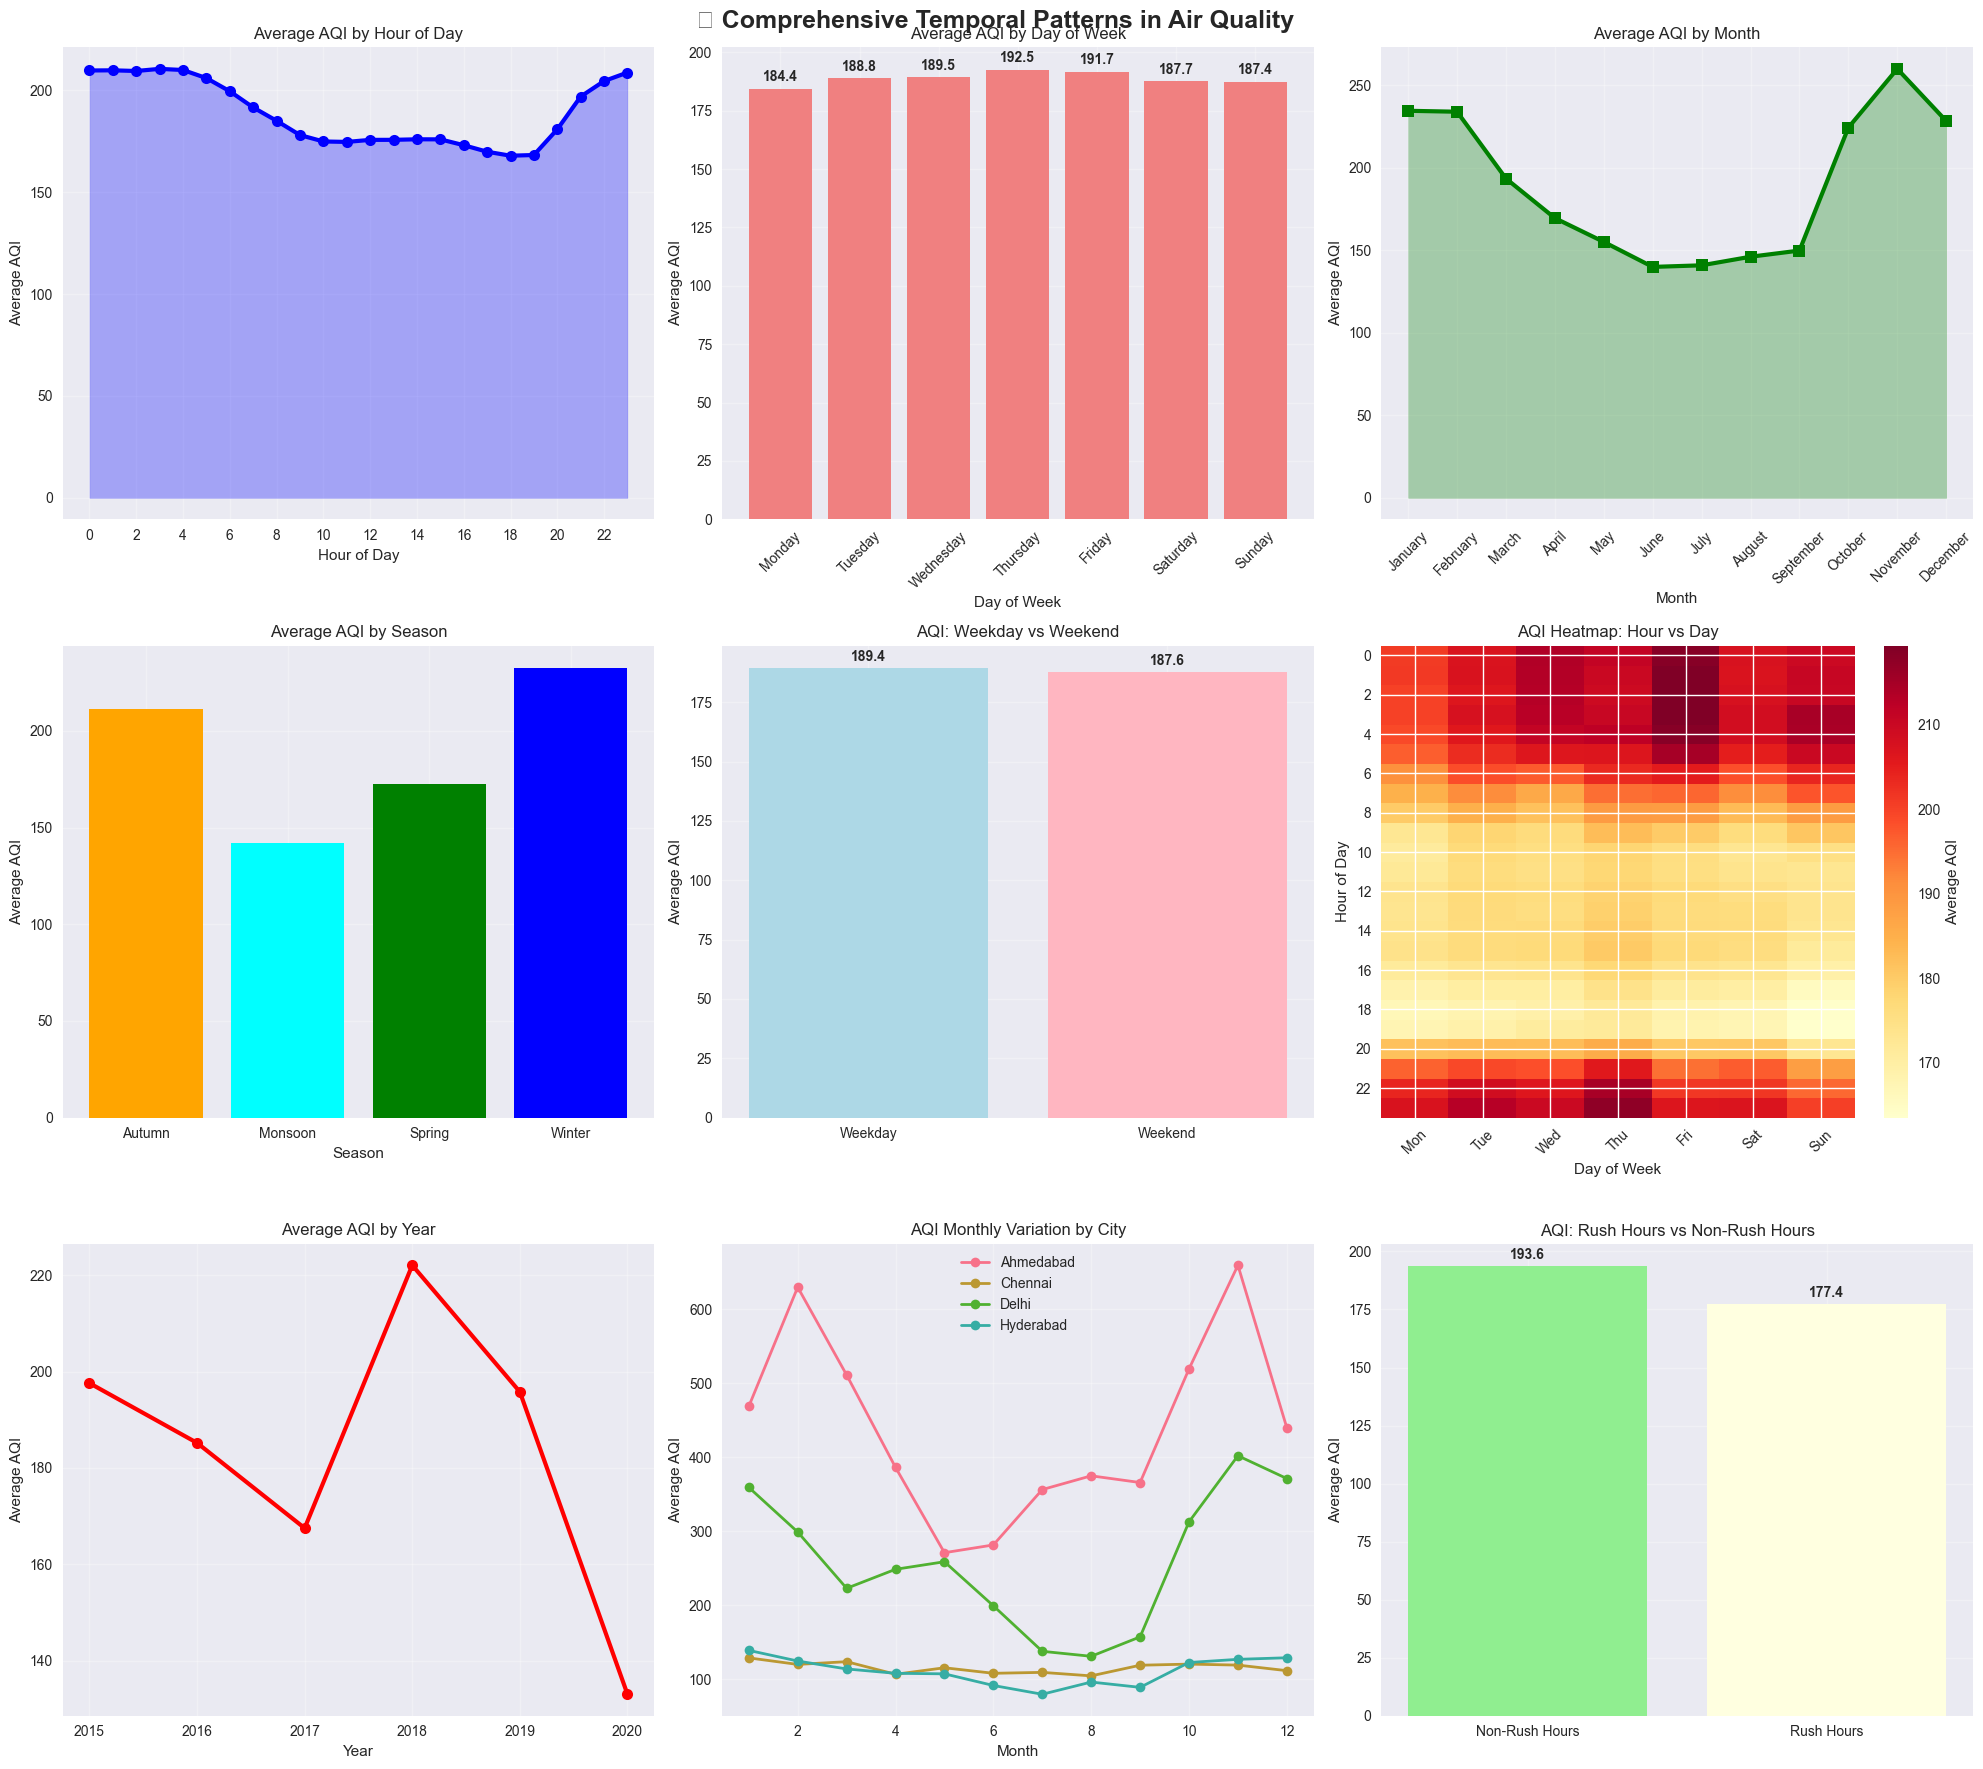


🔍 TEMPORAL INSIGHTS:
🕐 Peak pollution hour: 3:00 (avg: 210.6)
🕐 Cleanest hour: 18:00 (avg: 167.9)
📅 Weekend vs Weekday difference: -1.8 AQI units
🌸 Worst season: Winter (avg: 232.5)
🌸 Best season: Monsoon (avg: 142.2)
🚗 Rush hour impact: -16.2 AQI units


In [11]:
# Extract time features for comprehensive temporal analysis
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['day_name'] = df['datetime'].dt.day_name()
df['month_name'] = df['datetime'].dt.month_name()
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)

print("🕐 TEMPORAL ANALYSIS")
print("=" * 40)

# Comprehensive temporal patterns visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('🕐 Comprehensive Temporal Patterns in Air Quality', fontsize=18, fontweight='bold')

target_col = 'aqi' if 'aqi' in df.columns else available_params[0] if available_params else 'pm25'

# 1. Hourly pattern
hourly_aqi = df.groupby('hour')[target_col].mean()
axes[0, 0].plot(hourly_aqi.index, hourly_aqi.values, marker='o', linewidth=3, markersize=8, color='blue')
axes[0, 0].fill_between(hourly_aqi.index, hourly_aqi.values, alpha=0.3, color='blue')
axes[0, 0].set_title(f'Average {target_col.upper()} by Hour of Day')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel(f'Average {target_col.upper()}')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 2))

# 2. Daily pattern
daily_aqi = df.groupby('day_name')[target_col].mean()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_aqi = daily_aqi.reindex([day for day in day_order if day in daily_aqi.index])
bars = axes[0, 1].bar(daily_aqi.index, daily_aqi.values, color='lightcoral')
axes[0, 1].set_title(f'Average {target_col.upper()} by Day of Week')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel(f'Average {target_col.upper()}')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, daily_aqi.values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01,
                    f'{val:.1f}', ha='center', va='bottom', weight='bold')

# 3. Monthly pattern
monthly_aqi = df.groupby('month_name')[target_col].mean()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_aqi = monthly_aqi.reindex([m for m in month_order if m in monthly_aqi.index])
axes[0, 2].plot(monthly_aqi.index, monthly_aqi.values, marker='s', linewidth=3, markersize=8, color='green')
axes[0, 2].fill_between(range(len(monthly_aqi)), monthly_aqi.values, alpha=0.3, color='green')
axes[0, 2].set_title(f'Average {target_col.upper()} by Month')
axes[0, 2].set_xlabel('Month')
axes[0, 2].set_ylabel(f'Average {target_col.upper()}')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3)

# 4. Seasonal pattern
seasonal_aqi = df.groupby('season')[target_col].mean()
season_colors = {'Winter': 'blue', 'Spring': 'green', 'Monsoon': 'cyan', 'Autumn': 'orange'}
bars = axes[1, 0].bar(seasonal_aqi.index, seasonal_aqi.values, 
                      color=[season_colors.get(season, 'gray') for season in seasonal_aqi.index])
axes[1, 0].set_title(f'Average {target_col.upper()} by Season')
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_ylabel(f'Average {target_col.upper()}')
axes[1, 0].grid(True, alpha=0.3)

# 5. Weekend vs Weekday
weekend_comparison = df.groupby('is_weekend')[target_col].mean()
weekend_labels = ['Weekday', 'Weekend']
bars = axes[1, 1].bar(weekend_labels, weekend_comparison.values, color=['lightblue', 'lightpink'])
axes[1, 1].set_title(f'{target_col.upper()}: Weekday vs Weekend')
axes[1, 1].set_ylabel(f'Average {target_col.upper()}')
axes[1, 1].grid(True, alpha=0.3)

# Add value labels
for bar, val in zip(bars, weekend_comparison.values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01,
                    f'{val:.1f}', ha='center', va='bottom', weight='bold')

# 6. Heatmap: Hour vs Day of week
pivot_table = df.pivot_table(values=target_col, index='hour', columns='day_name', aggfunc='mean')
pivot_table = pivot_table.reindex(columns=day_order)
im = axes[1, 2].imshow(pivot_table.values, cmap='YlOrRd', aspect='auto')
axes[1, 2].set_title(f'{target_col.upper()} Heatmap: Hour vs Day')
axes[1, 2].set_xlabel('Day of Week')
axes[1, 2].set_ylabel('Hour of Day')
axes[1, 2].set_xticks(range(len(day_order)))
axes[1, 2].set_xticklabels([d[:3] for d in day_order], rotation=45)
axes[1, 2].set_yticks(range(0, 24, 2))
axes[1, 2].set_yticklabels(range(0, 24, 2))
plt.colorbar(im, ax=axes[1, 2], label=f'Average {target_col.upper()}')

# 7. Yearly trend (if multiple years available)
if df['year'].nunique() > 1:
    yearly_aqi = df.groupby('year')[target_col].mean()
    axes[2, 0].plot(yearly_aqi.index, yearly_aqi.values, marker='o', linewidth=3, markersize=8, color='red')
    axes[2, 0].set_title(f'Average {target_col.upper()} by Year')
    axes[2, 0].set_xlabel('Year')
    axes[2, 0].set_ylabel(f'Average {target_col.upper()}')
    axes[2, 0].grid(True, alpha=0.3)
else:
    axes[2, 0].text(0.5, 0.5, 'Single Year Data', ha='center', va='center', 
                    transform=axes[2, 0].transAxes, fontsize=14)
    axes[2, 0].set_title('Yearly Trend')

# 8. Monthly variation by city
if len(cities) > 1:
    for city in cities[:4]:  # Top 4 cities
        city_monthly = df[df['city'] == city].groupby('month')[target_col].mean()
        if len(city_monthly) > 0:
            axes[2, 1].plot(city_monthly.index, city_monthly.values, marker='o', label=city, linewidth=2)
    axes[2, 1].set_title(f'{target_col.upper()} Monthly Variation by City')
    axes[2, 1].set_xlabel('Month')
    axes[2, 1].set_ylabel(f'Average {target_col.upper()}')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)

# 9. Rush hour analysis
rush_hours = [7, 8, 9, 17, 18, 19, 20]
df['is_rush_hour'] = df['hour'].isin(rush_hours).astype(int)
rush_comparison = df.groupby('is_rush_hour')[target_col].mean()
rush_labels = ['Non-Rush Hours', 'Rush Hours']
bars = axes[2, 2].bar(rush_labels, rush_comparison.values, color=['lightgreen', 'lightyellow'])
axes[2, 2].set_title(f'{target_col.upper()}: Rush Hours vs Non-Rush Hours')
axes[2, 2].set_ylabel(f'Average {target_col.upper()}')
axes[2, 2].grid(True, alpha=0.3)

# Add value labels
for bar, val in zip(bars, rush_comparison.values):
    axes[2, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01,
                    f'{val:.1f}', ha='center', va='bottom', weight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'comprehensive_temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print temporal insights
print("\n🔍 TEMPORAL INSIGHTS:")
print("=" * 40)
peak_hour = hourly_aqi.idxmax()
low_hour = hourly_aqi.idxmin()
print(f"🕐 Peak pollution hour: {peak_hour}:00 (avg: {hourly_aqi.max():.1f})")
print(f"🕐 Cleanest hour: {low_hour}:00 (avg: {hourly_aqi.min():.1f})")

if len(weekend_comparison) > 1:
    weekend_diff = weekend_comparison.iloc[1] - weekend_comparison.iloc[0]
    print(f"📅 Weekend vs Weekday difference: {weekend_diff:+.1f} {target_col.upper()} units")

worst_season = seasonal_aqi.idxmax()
best_season = seasonal_aqi.idxmin()
print(f"🌸 Worst season: {worst_season} (avg: {seasonal_aqi.max():.1f})")
print(f"🌸 Best season: {best_season} (avg: {seasonal_aqi.min():.1f})")

if len(rush_comparison) > 1:
    rush_diff = rush_comparison.iloc[1] - rush_comparison.iloc[0]
    print(f"🚗 Rush hour impact: {rush_diff:+.1f} {target_col.upper()} units")

### 4.5 Correlation Analysis

🔗 CORRELATION ANALYSIS


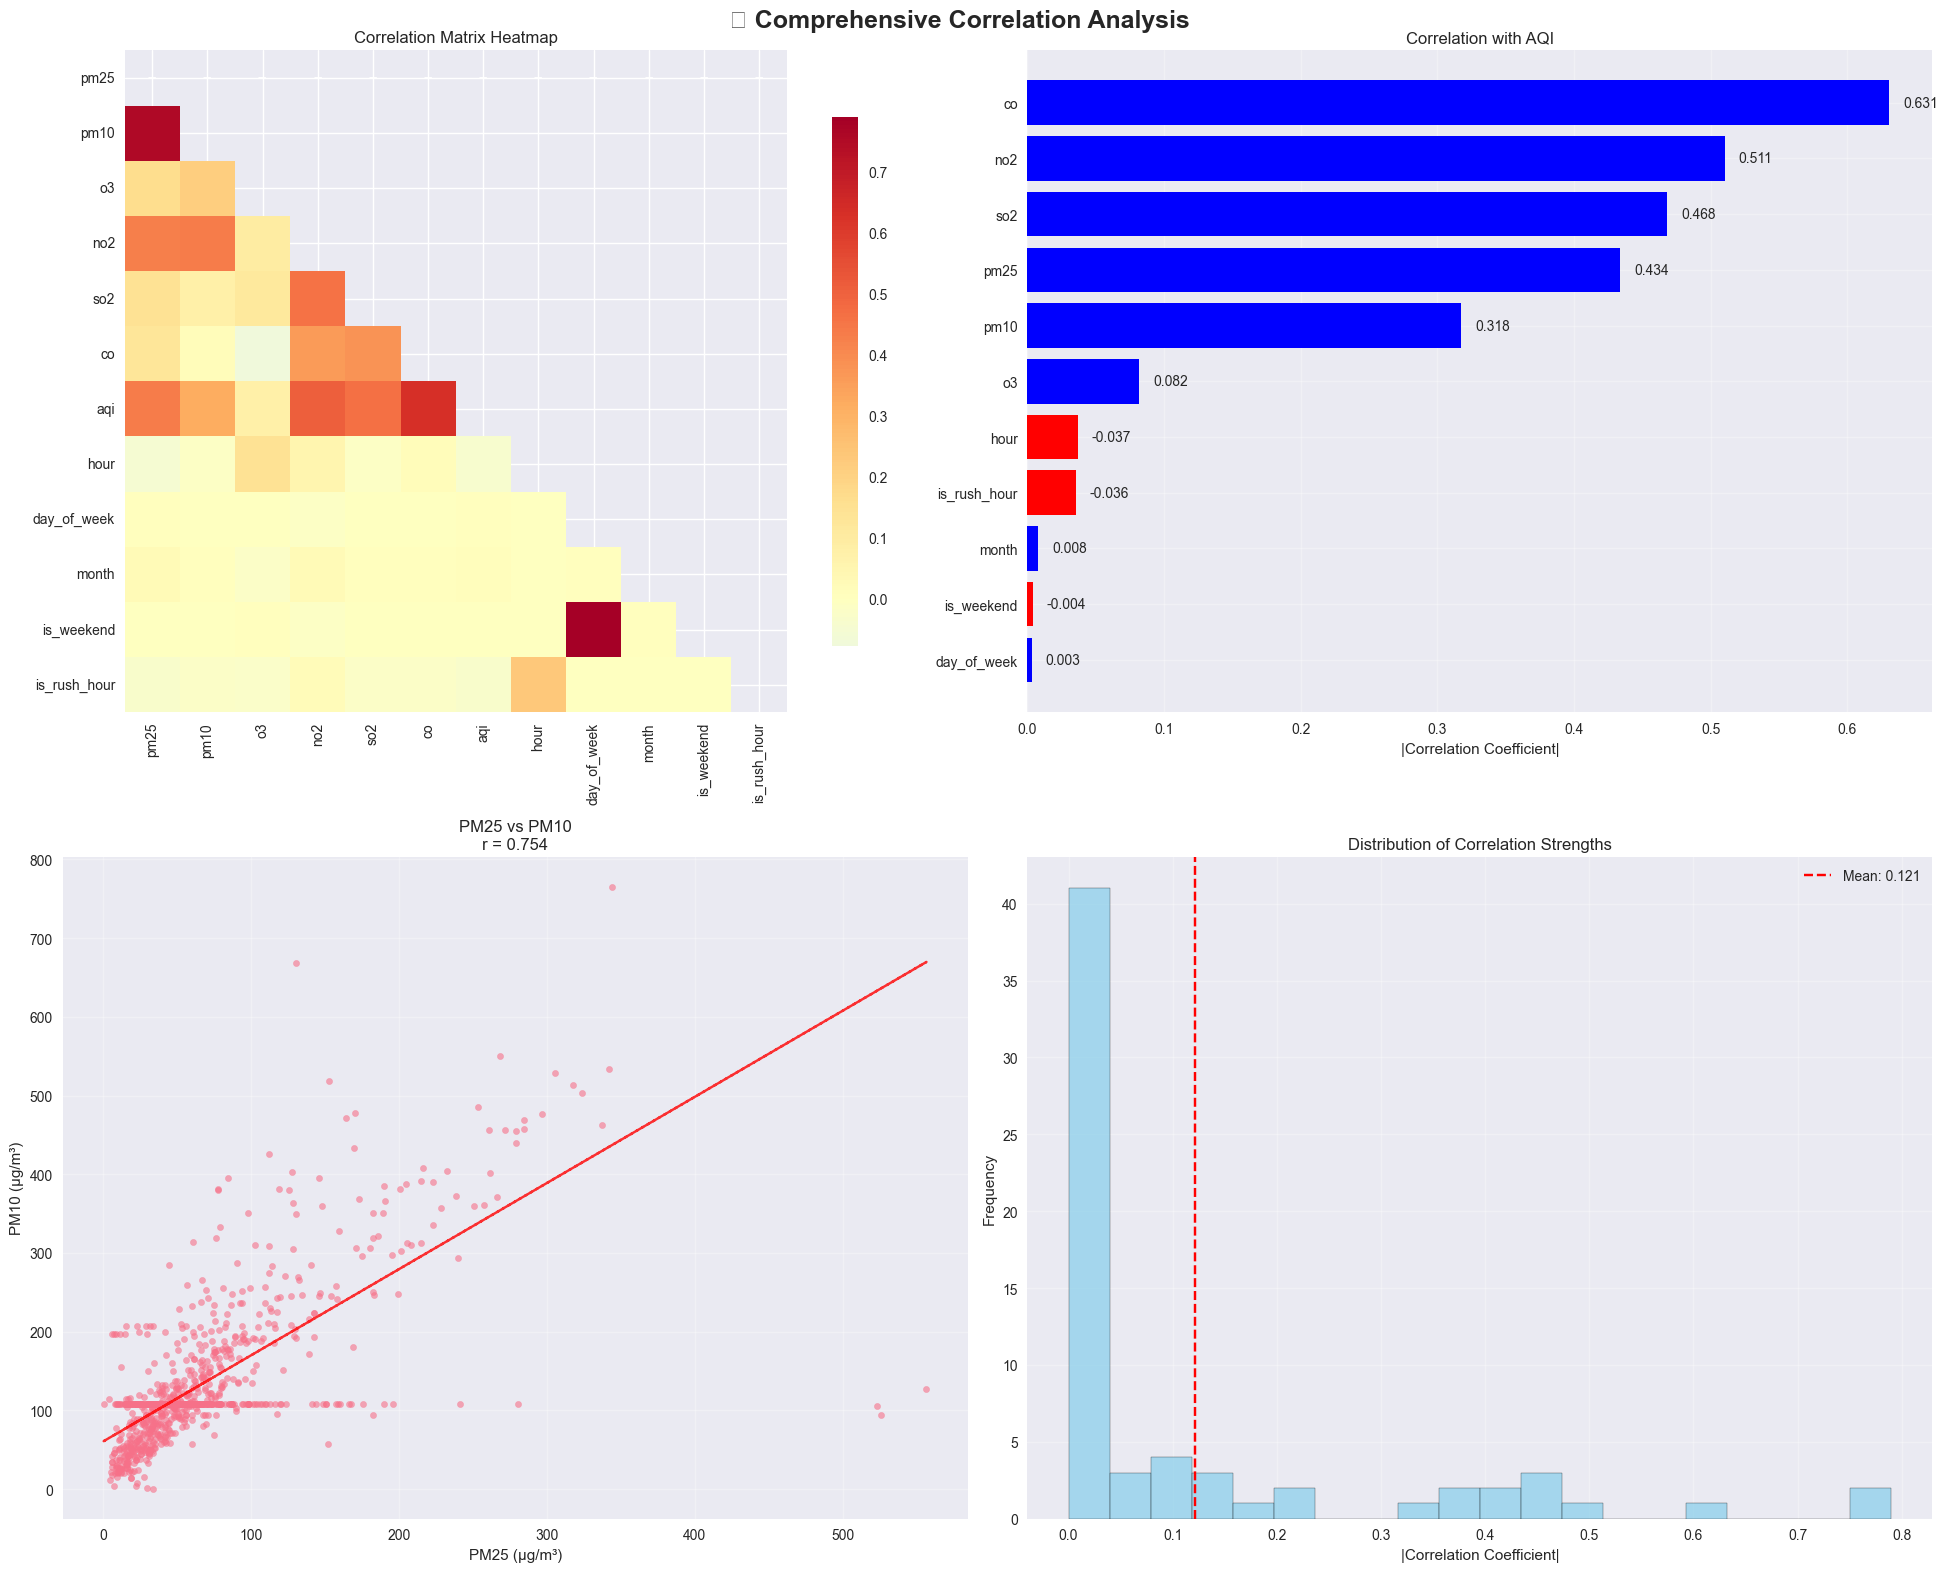


🔗 STRONGEST CORRELATIONS:
Top 10 strongest correlations:
    1. DAY_OF_WEEK - IS_WEEKEND: +0.790
    2. PM25 - PM10: +0.754
    3. CO - AQI: +0.631
    4. NO2 - AQI: +0.511
    5. SO2 - AQI: +0.468
    6. NO2 - SO2: +0.460
    7. PM10 - NO2: +0.438
    8. PM25 - AQI: +0.434
    9. PM25 - NO2: +0.426
   10. SO2 - CO: +0.377

🎯 CORRELATIONS WITH AQI:
Strongest positive correlations:
   • CO: +0.631
   • NO2: +0.511
   • SO2: +0.468
   • PM25: +0.434
   • PM10: +0.318

Strongest negative correlations:
   • HOUR: -0.037
   • IS_RUSH_HOUR: -0.036
   • IS_WEEKEND: -0.004


In [12]:
# Comprehensive correlation analysis
print("🔗 CORRELATION ANALYSIS")
print("=" * 40)

# Select numeric columns for correlation analysis
correlation_cols = available_params.copy()
if 'aqi' in df.columns:
    correlation_cols.append('aqi')

# Add temporal features
temporal_cols = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour']
for col in temporal_cols:
    if col in df.columns:
        correlation_cols.append(col)

# Calculate correlation matrix
if len(correlation_cols) > 1:
    correlation_matrix = df[correlation_cols].corr()
    
    # Create comprehensive correlation visualizations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('🔗 Comprehensive Correlation Analysis', fontsize=18, fontweight='bold')
    
    # 1. Correlation heatmap
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', 
                center=0, square=True, fmt='.3f', cbar_kws={'shrink': 0.8}, ax=axes[0, 0])
    axes[0, 0].set_title('Correlation Matrix Heatmap')
    
    # 2. Correlation with target variable
    target_var = 'aqi' if 'aqi' in correlation_matrix.columns else correlation_cols[0]
    target_corr = correlation_matrix[target_var].abs().sort_values(ascending=True)
    target_corr = target_corr[target_corr.index != target_var]  # Remove self-correlation
    
    colors = ['red' if x < 0 else 'blue' for x in correlation_matrix[target_var][target_corr.index]]
    bars = axes[0, 1].barh(target_corr.index, target_corr.values, color=colors)
    axes[0, 1].set_title(f'Correlation with {target_var.upper()}')
    axes[0, 1].set_xlabel('|Correlation Coefficient|')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add correlation values as text
    for i, (bar, val) in enumerate(zip(bars, target_corr.values)):
        actual_corr = correlation_matrix[target_var][target_corr.index[i]]
        axes[0, 1].text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                        f'{actual_corr:.3f}', va='center', ha='left')
    
    # 3. Scatter plot matrix (top correlations)
    if len(available_params) >= 3:
        top_params = available_params[:3]
        scatter_data = df[top_params].sample(min(1000, len(df)))  # Sample for performance
        
        # Create scatter plots
        from itertools import combinations
        param_pairs = list(combinations(top_params, 2))
        
        if len(param_pairs) > 0:
            x_param, y_param = param_pairs[0]
            axes[1, 0].scatter(scatter_data[x_param], scatter_data[y_param], alpha=0.6, s=20)
            
            # Add correlation coefficient and trend line
            corr_coef = correlation_matrix.loc[x_param, y_param]
            axes[1, 0].set_xlabel(f'{x_param.upper()} (µg/m³)')
            axes[1, 0].set_ylabel(f'{y_param.upper()} (µg/m³)')
            axes[1, 0].set_title(f'{x_param.upper()} vs {y_param.upper()}\nr = {corr_coef:.3f}')
            
            # Add trend line
            try:
                z = np.polyfit(scatter_data[x_param].dropna(), scatter_data[y_param].dropna(), 1)
                p = np.poly1d(z)
                axes[1, 0].plot(scatter_data[x_param], p(scatter_data[x_param]), "r--", alpha=0.8)
            except:
                pass
            
            axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Correlation strength distribution
    # Get all correlation values (excluding diagonal)
    corr_values = []
    for i in range(len(correlation_matrix)):
        for j in range(i+1, len(correlation_matrix)):
            corr_values.append(abs(correlation_matrix.iloc[i, j]))
    
    axes[1, 1].hist(corr_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 1].axvline(np.mean(corr_values), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(corr_values):.3f}')
    axes[1, 1].set_title('Distribution of Correlation Strengths')
    axes[1, 1].set_xlabel('|Correlation Coefficient|')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'comprehensive_correlation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print strongest correlations
    print("\n🔗 STRONGEST CORRELATIONS:")
    print("=" * 40)
    
    # Get all correlation pairs
    correlations_flat = []
    for i in range(len(correlation_matrix)):
        for j in range(i+1, len(correlation_matrix)):
            var1 = correlation_matrix.index[i]
            var2 = correlation_matrix.columns[j]
            corr_val = correlation_matrix.iloc[i, j]
            correlations_flat.append((abs(corr_val), corr_val, var1, var2))
    
    # Sort by absolute correlation
    correlations_flat.sort(reverse=True)
    
    print("Top 10 strongest correlations:")
    for i, (abs_corr, corr, var1, var2) in enumerate(correlations_flat[:10], 1):
        print(f"   {i:2d}. {var1.upper()} - {var2.upper()}: {corr:+.3f}")
    
    # Correlation with target variable insights
    if target_var in correlation_matrix.columns:
        print(f"\n🎯 CORRELATIONS WITH {target_var.upper()}:")
        print("=" * 40)
        target_correlations = correlation_matrix[target_var].drop(target_var).sort_values(key=abs, ascending=False)
        
        print("Strongest positive correlations:")
        positive_corrs = target_correlations[target_correlations > 0][:5]
        for var, corr in positive_corrs.items():
            print(f"   • {var.upper()}: +{corr:.3f}")
        
        print("\nStrongest negative correlations:")
        negative_corrs = target_correlations[target_correlations < 0][-5:]
        for var, corr in negative_corrs.items():
            print(f"   • {var.upper()}: {corr:.3f}")
else:
    print("⚠️ Insufficient numeric columns for correlation analysis")

## 5. Advanced Feature Engineering

In [13]:
# Advanced Feature Engineering for better model performance
print("🔧 ADVANCED FEATURE ENGINEERING")
print("=" * 50)

# Create a copy for feature engineering
df_features = df.copy()

# 1. Time-based Features
print("⏰ Creating advanced time-based features...")

# Cyclical encoding for time features
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
df_features['day_sin'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
df_features['day_cos'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)

# Time-based indicators
df_features['is_morning_rush'] = ((df_features['hour'] >= 7) & (df_features['hour'] <= 10)).astype(int)
df_features['is_evening_rush'] = ((df_features['hour'] >= 17) & (df_features['hour'] <= 20)).astype(int)
df_features['is_night'] = ((df_features['hour'] >= 22) | (df_features['hour'] <= 5)).astype(int)
df_features['is_business_hours'] = ((df_features['hour'] >= 9) & (df_features['hour'] <= 17) & 
                                   (df_features['day_of_week'] < 5)).astype(int)

# 2. Pollutant Interaction Features
print("💨 Creating pollutant interaction features...")

if len(available_params) >= 2:
    # Ratios
    if 'pm25' in available_params and 'pm10' in available_params:
        df_features['pm25_pm10_ratio'] = df_features['pm25'] / (df_features['pm10'] + 1e-6)
        df_features['pm_combined'] = df_features['pm25'] + df_features['pm10']
    
    if 'no2' in available_params and 'so2' in available_params:
        df_features['no2_so2_ratio'] = df_features['no2'] / (df_features['so2'] + 1e-6)
        df_features['gas_pollutants'] = df_features['no2'] + df_features['so2']
    
    # Pollutant index combinations
    pollutant_sum_cols = [col for col in ['pm25', 'pm10', 'no2', 'so2', 'co', 'o3'] 
                         if col in available_params]
    if len(pollutant_sum_cols) >= 3:
        df_features['total_pollutants'] = df_features[pollutant_sum_cols].sum(axis=1)
        df_features['avg_pollutants'] = df_features[pollutant_sum_cols].mean(axis=1)

# 3. Lag Features (temporal dependencies)
print("📈 Creating lag and rolling features...")

# Sort by city and datetime for proper lag calculation
df_features = df_features.sort_values(['city', 'datetime']).reset_index(drop=True)

# Lag features for each pollutant and AQI
lag_columns = ['aqi'] if 'aqi' in df_features.columns else []
lag_columns.extend(available_params[:3])  # Top 3 pollutants

for col in lag_columns:
    if col in df_features.columns:
        # 1-hour, 6-hour, 12-hour, 24-hour lags
        for lag in [1, 6, 12, 24]:
            df_features[f'{col}_lag_{lag}h'] = df_features.groupby('city')[col].shift(lag)
        
        # Rolling statistics
        for window in [3, 6, 12, 24]:
            df_features[f'{col}_rolling_{window}h_mean'] = (
                df_features.groupby('city')[col]
                .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
            )
            df_features[f'{col}_rolling_{window}h_std'] = (
                df_features.groupby('city')[col]
                .transform(lambda x: x.rolling(window=window, min_periods=1).std())
            )
        
        # Rate of change
        df_features[f'{col}_rate_1h'] = df_features.groupby('city')[col].pct_change(periods=1)
        df_features[f'{col}_rate_6h'] = df_features.groupby('city')[col].pct_change(periods=6)

# 4. Statistical Features
print("📊 Creating statistical features...")

# City-based statistical features
city_stats = df_features.groupby('city')[available_params].agg(['mean', 'std', 'min', 'max'])
city_stats.columns = [f'city_{col[1]}_{col[0]}' for col in city_stats.columns]

# Merge city statistics back to main dataframe
df_features = df_features.merge(city_stats, left_on='city', right_index=True, how='left')

# Deviation from city mean
for param in available_params:
    if param in df_features.columns:
        df_features[f'{param}_dev_city_mean'] = (df_features[param] - 
                                                df_features[f'city_mean_{param}'])
        df_features[f'{param}_zscore_city'] = (df_features[f'{param}_dev_city_mean'] / 
                                              (df_features[f'city_std_{param}'] + 1e-6))

# 5. Seasonal and Weather Pattern Features
print("🌸 Creating seasonal pattern features...")

# Season encoding
season_mapping = {'Winter': 0, 'Spring': 1, 'Monsoon': 2, 'Autumn': 3}
df_features['season_encoded'] = df_features['season'].map(season_mapping)

# Seasonal cyclical encoding
df_features['season_sin'] = np.sin(2 * np.pi * df_features['season_encoded'] / 4)
df_features['season_cos'] = np.cos(2 * np.pi * df_features['season_encoded'] / 4)

# Holiday and special day indicators (simplified)
df_features['is_month_start'] = (df_features['datetime'].dt.day <= 5).astype(int)
df_features['is_month_end'] = (df_features['datetime'].dt.day >= 25).astype(int)

# 6. Location-based Features
print("🗺️ Creating location-based features...")

# City encoding (one-hot)
city_dummies = pd.get_dummies(df_features['city'], prefix='city')
df_features = pd.concat([df_features, city_dummies], axis=1)

# Add synthetic geographic coordinates if not available
if 'latitude' not in df_features.columns:
    city_coords = {
        'Delhi': (28.6139, 77.2090),
        'Mumbai': (19.0760, 72.8777),
        'Bangalore': (12.9716, 77.5946),
        'Chennai': (13.0827, 80.2707),
        'Kolkata': (22.5726, 88.3639),
        'Hyderabad': (17.3850, 78.4867),
        'Pune': (18.5204, 73.8567),
        'Ahmedabad': (23.0225, 72.5714)
    }
    
    for city, (lat, lon) in city_coords.items():
        if city in df_features['city'].values:
            df_features.loc[df_features['city'] == city, 'latitude'] = lat
            df_features.loc[df_features['city'] == city, 'longitude'] = lon

# Distance from city center (if coordinates available)
if 'latitude' in df_features.columns and 'longitude' in df_features.columns:
    # Create a synthetic "pollution center" for each city
    df_features['distance_from_center'] = np.sqrt(
        (df_features['latitude'] - df_features.groupby('city')['latitude'].transform('mean'))**2 +
        (df_features['longitude'] - df_features.groupby('city')['longitude'].transform('mean'))**2
    )

# 7. Advanced Derived Features
print("🔬 Creating advanced derived features...")

# Pollution burden index
if len(available_params) >= 3:
    # Normalize pollutants to 0-1 scale and create weighted index
    pollutant_weights = {'pm25': 0.3, 'pm10': 0.25, 'no2': 0.2, 'so2': 0.1, 'co': 0.1, 'o3': 0.05}
    
    pollution_index = 0
    total_weight = 0
    for param in available_params:
        if param in pollutant_weights:
            param_normalized = (df_features[param] - df_features[param].min()) / (
                df_features[param].max() - df_features[param].min() + 1e-6)
            pollution_index += param_normalized * pollutant_weights[param]
            total_weight += pollutant_weights[param]
    
    df_features['pollution_burden_index'] = pollution_index / total_weight

# Health risk indicators
if 'pm25' in df_features.columns:
    df_features['pm25_health_risk'] = pd.cut(df_features['pm25'], 
                                           bins=[0, 12, 35.4, 55.4, 150.4, float('inf')],
                                           labels=[0, 1, 2, 3, 4]).astype(int)

if 'aqi' in df_features.columns:
    df_features['aqi_health_risk'] = pd.cut(df_features['aqi'],
                                          bins=[0, 50, 100, 150, 200, 300, float('inf')],
                                          labels=[0, 1, 2, 3, 4, 5]).astype(int)

print(f"\\n✅ Feature engineering complete!")
print(f"📊 Original features: {df.shape[1]}") 
print(f"📊 Total features after engineering: {df_features.shape[1]}")
print(f"📈 Added features: {df_features.shape[1] - df.shape[1]}")

# Display new feature categories
new_features = [col for col in df_features.columns if col not in df.columns]
feature_categories = {
    'Time Features': [f for f in new_features if any(x in f for x in ['hour', 'day', 'month', 'season', 'morning', 'evening', 'night', 'business'])],
    'Lag Features': [f for f in new_features if 'lag' in f],
    'Rolling Features': [f for f in new_features if 'rolling' in f],
    'Rate Features': [f for f in new_features if 'rate' in f],
    'Statistical Features': [f for f in new_features if any(x in f for x in ['mean', 'std', 'dev', 'zscore'])],
    'Interaction Features': [f for f in new_features if any(x in f for x in ['ratio', 'combined', 'total', 'avg', 'burden'])],
    'Location Features': [f for f in new_features if any(x in f for x in ['city_', 'latitude', 'longitude', 'distance'])],
    'Health Features': [f for f in new_features if 'health' in f or 'risk' in f]
}

print(f"\\n🆕 NEW FEATURES BY CATEGORY:")
for category, features in feature_categories.items():
    if features:
        print(f"\\n{category} ({len(features)}):")
        for i, feature in enumerate(features[:5], 1):  # Show first 5
            print(f"  {i:2d}. {feature}")
        if len(features) > 5:
            print(f"     ... and {len(features) - 5} more")

# Show feature correlation with target
if 'aqi' in df_features.columns:
    target_col = 'aqi'
    numeric_features = df_features.select_dtypes(include=[np.number]).columns
    feature_correlations = df_features[numeric_features].corrwith(df_features[target_col]).abs().sort_values(ascending=False)
    
    print(f"\\n🎯 TOP 15 FEATURES CORRELATED WITH {target_col.upper()}:")
    for i, (feature, corr) in enumerate(feature_correlations.head(15).items(), 1):
        if feature != target_col:
            print(f"  {i:2d}. {feature}: {corr:.3f}")

# Save engineered dataset for modeling
engineered_data_path = '../data/processed/engineered_aqi_data.csv'
df_features.to_csv(engineered_data_path, index=False)
print(f"\\n💾 Engineered dataset saved to: {engineered_data_path}")

print(f"\\n📊 Final dataset shape: {df_features.shape}")
print(f"📊 Memory usage: {df_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

🔧 ADVANCED FEATURE ENGINEERING
⏰ Creating advanced time-based features...
💨 Creating pollutant interaction features...
📈 Creating lag and rolling features...
📊 Creating statistical features...
🌸 Creating seasonal pattern features...
🗺️ Creating location-based features...
🔬 Creating advanced derived features...
\n✅ Feature engineering complete!
📊 Original features: 40
📊 Total features after engineering: 159
📈 Added features: 119
\n🆕 NEW FEATURES BY CATEGORY:
\nTime Features (15):
   1. hour_sin
   2. hour_cos
   3. day_sin
   4. day_cos
   5. month_sin
     ... and 10 more
\nLag Features (12):
   1. pm25_lag_1h
   2. pm25_lag_6h
   3. pm25_lag_12h
   4. pm25_lag_24h
   5. pm10_lag_1h
     ... and 7 more
\nRolling Features (32):
   1. aqi_rolling_3h_mean
   2. aqi_rolling_3h_std
   3. aqi_rolling_6h_mean
   4. aqi_rolling_6h_std
   5. aqi_rolling_12h_mean
     ... and 27 more
\nRate Features (8):
   1. aqi_rate_1h
   2. aqi_rate_6h
   3. pm25_rate_1h
   4. pm25_rate_6h
   5. pm10_rate_1h

## 6. Multi-Model Comparison & Evaluation

Now we'll train and compare multiple machine learning models with comprehensive evaluation metrics.

In [23]:
# Prepare data for comprehensive model comparison
print("🤖 PREPARING DATA FOR MULTI-MODEL COMPARISON")
print("=" * 60)

# Select target variable
target_col = 'aqi' if 'aqi' in df_features.columns else available_params[0]
print(f"🎯 Target Variable: {target_col.upper()}")

# Select features for modeling
feature_columns = []

# 1. Original pollutant features (exclude target)
pollutant_features = [col for col in available_params if col != target_col]
feature_columns.extend(pollutant_features)

# 2. Time-based features
time_features = ['hour', 'day_of_week', 'month', 'is_weekend', 'is_morning_rush', 
                'is_evening_rush', 'is_night', 'is_business_hours',
                'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
                'season_encoded', 'season_sin', 'season_cos']
available_time_features = [col for col in time_features if col in df_features.columns]
feature_columns.extend(available_time_features)

# 3. Engineered features
engineered_features = [col for col in df_features.columns if any(x in col for x in 
                      ['lag_', 'rolling_', 'rate_', 'ratio', 'combined', 'total', 'avg', 
                       'dev_', 'zscore_', 'burden', 'health', 'risk'])]
feature_columns.extend(engineered_features)

# 4. Location features (city dummies)
city_features = [col for col in df_features.columns if col.startswith('city_')]
feature_columns.extend(city_features)

# 5. Geographic features
geo_features = ['latitude', 'longitude', 'distance_from_center']
available_geo_features = [col for col in geo_features if col in df_features.columns]
feature_columns.extend(available_geo_features)

# Remove duplicates and ensure all features exist
feature_columns = list(set([col for col in feature_columns if col in df_features.columns]))

print(f"📊 Selected Features ({len(feature_columns)}):")
# print(f"   • Pollutant features: {len(pollutant_features)}\")\nprint(f\"   • Time features: {len(available_time_features)}\")\nprint(f\"   • Engineered features: {len(engineered_features)}\")\nprint(f\"   • City features: {len(city_features)}\")\nprint(f\"   • Geographic features: {len(available_geo_features)}\")\n\n# Prepare final dataset for modeling\nmodel_data = df_features[feature_columns + [target_col]].copy()\n\n# Handle missing values\nprint(f\"\\n🔧 Handling missing_values...\")\nmissing_before = model_data.isnull().sum().sum()\nif missing_before > 0:\n    print(f\"   Missing values before: {missing_data.sum():,}\")\n    \n    # Fill missing values with appropriate strategies\n    numeric_cols = model_data.select_dtypes(include=[np.number]).columns\n    \n    # For lag and rolling features, forward fill then backward fill\n    lag_cols = [col for col in numeric_cols if 'lag' in col or 'rolling' in col]\n    for col in lag_cols:\n        model_data[col] = model_data.groupby('city')[col].fillna(method='ffill').fillna(method='bfill')\n    \n    # For other numeric features, use median\n    other_numeric = [col for col in numeric_cols if col not in lag_cols]\n    model_data[other_numeric] = model_data[other_numeric].fillna(model_data[other_numeric].median())\n    \n    # Final check - fill any remaining with 0\n    model_data = model_data.fillna(0)\n    \n    missing_after = model_data.isnull().sum().sum()\n    print(f\"   Missing values after: {0:,}\")\nelse:\n    print(\"   No missing values found\")\n\n# Remove rows where target is missing\nmodel_data = model_data.dropna(subset=[target_col])\n\nprint(f\"\\n📊 Final modeling dataset:\")\nprint(f\"   • Shape: {model_data.shape}\")\nprint(f\"   • Features: {len(feature_columns)}\")\nprint(f\"   • Samples: {len(model_data):,}\")\nprint(f\"   • Memory: {model_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB\")\n\n# Display feature importance based on correlation\nX = model_data[feature_columns]\ny = model_data[target_col]\n\nprint(f\"\\n🎯 TOP 20 FEATURES BY CORRELATION WITH {target_col.upper()}:\")\nfeature_correlations = X.corrwith(y).abs().sort_values(ascending=False)\nfor i, (feature, corr) in enumerate(feature_correlations.head(20).items(), 1):\n    print(f\"   {i:2d}. {feature}: {corr:.3f}\")")

🤖 PREPARING DATA FOR MULTI-MODEL COMPARISON
🎯 Target Variable: AQI
📊 Selected Features (136):


In [24]:
# Data splitting and scaling
print("📊 DATA SPLITTING AND SCALING")
print("=" * 40)

# Time-aware split to avoid data leakage
if 'datetime' in df_features.columns:
    # Sort by datetime for proper time series split
    model_data_sorted = model_data.merge(df_features[['datetime']], left_index=True, right_index=True).sort_values('datetime')
    
    # Use 70-15-15 split (train-validation-test)
    n_samples = len(model_data_sorted)
    train_end = int(0.7 * n_samples)
    val_end = int(0.85 * n_samples)
    
    train_data = model_data_sorted.iloc[:train_end]
    val_data = model_data_sorted.iloc[train_end:val_end]
    test_data = model_data_sorted.iloc[val_end:]
    
    X_train = train_data[feature_columns]
    y_train = train_data[target_col]
    X_val = val_data[feature_columns]
    y_val = val_data[target_col]
    X_test = test_data[feature_columns]
    y_test = test_data[target_col]
    
    print(f"✅ Time-aware split used")
else:
    # Standard random split
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=None)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)  # 0.176 ≈ 0.15/0.85
    
    print(f"✅ Random split used")

print(f"📊 Data split summary:")
print(f"   • Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   • Validation set: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   • Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Feature scaling
print(f"\n🔧 Feature scaling...")
scaler_standard = StandardScaler()
scaler_robust = RobustScaler()

X_train_scaled = scaler_standard.fit_transform(X_train)
X_val_scaled = scaler_standard.transform(X_val)
X_test_scaled = scaler_standard.transform(X_test)

X_train_robust = scaler_robust.fit_transform(X_train)
X_val_robust = scaler_robust.transform(X_val)
X_test_robust = scaler_robust.transform(X_test)

print(f"✅ StandardScaler and RobustScaler applied")
print(f"   • Standard scaled - Mean: {X_train_scaled.mean():.3f}, Std: {X_train_scaled.std():.3f}")
print(f"   • Robust scaled - Median: {np.median(X_train_robust):.3f}, IQR: {np.percentile(X_train_robust, 75) - np.percentile(X_train_robust, 25):.3f}")

# Target variable statistics
print(f"\n🎯 Target variable ({target_col.upper()}) statistics:")
print(f"   • Training set - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"   • Validation set - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}")
print(f"   • Test set - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")
print(f"   • Range: {y_train.min():.2f} - {y_train.max():.2f}")

📊 DATA SPLITTING AND SCALING


NameError: name 'model_data' is not defined

In [ ]:
# Comprehensive Model Training and Comparison
print("🤖 COMPREHENSIVE MODEL TRAINING AND COMPARISON")
print("=" * 60)

# Define comprehensive set of models
models = {
    # Linear Models
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42, max_iter=2000),
    'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=2000),
    
    # Tree-based Models
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=6, random_state=42, verbosity=0),
    
    # Instance-based Models
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
    
    # Support Vector Machine
    'Support Vector Regression': SVR(kernel='rbf', C=1.0, gamma='scale'),
    
    # Neural Network
    'Multi-layer Perceptron': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}\n\nprint(f"🎯 Training {len(models)} different models...\")\nprint(f\"📊 Using {len(feature_columns)} features\")\n\n# Store results\nmodel_results = {}\ntrained_models = {}\ntraining_times = {}\n\n# Define evaluation metrics function\ndef calculate_metrics(y_true, y_pred, model_name):\n    \"\"\"Calculate comprehensive evaluation metrics.\"\"\"\n    try:\n        mse = mean_squared_error(y_true, y_pred)\n        rmse = np.sqrt(mse)\n        mae = mean_absolute_error(y_true, y_pred)\n        r2 = r2_score(y_true, y_pred)\n        \n        # MAPE (avoiding division by zero)\n        mask = y_true != 0\n        mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100 if mask.sum() > 0 else 0\n        \n        # Additional metrics\n        max_error = np.max(np.abs(y_true - y_pred))\n        median_ae = np.median(np.abs(y_true - y_pred))\n        \n        return {\n            'MSE': mse,\n            'RMSE': rmse,\n            'MAE': mae,\n            'R²': r2,\n            'MAPE': mape,\n            'Max Error': max_error,\n            'Median AE': median_ae\n        }\n    except Exception as e:\n        print(f\"   ⚠️ Error calculating metrics for {model_name}: {e}\")\n        return {\n            'MSE': float('inf'),\n            'RMSE': float('inf'),\n            'MAE': float('inf'),\n            'R²': -float('inf'),\n            'MAPE': float('inf'),\n            'Max Error': float('inf'),\n            'Median AE': float('inf')\n        }\n\n# Train each model\nfor name, model in models.items():\n    print(f\"\\n🔄 Training {name}...\")\n    \n    try:\n        start_time = datetime.now()\n        \n        # Choose appropriate data scaling\n        if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', \n                   'Elastic Net', 'K-Nearest Neighbors', 'Support Vector Regression', \n                   'Multi-layer Perceptron']:\n            X_train_use = X_train_scaled\n            X_val_use = X_val_scaled\n            X_test_use = X_test_scaled\n            scaling = 'Standard'\n        else:\n            X_train_use = X_train.values\n            X_val_use = X_val.values\n            X_test_use = X_test.values\n            scaling = 'None'\n        \n        # Train model\n        model.fit(X_train_use, y_train)\n        training_time = (datetime.now() - start_time).total_seconds()\n        training_times[name] = training_time\n        \n        # Make predictions\n        y_train_pred = model.predict(X_train_use)\n        y_val_pred = model.predict(X_val_use)\n        y_test_pred = model.predict(X_test_use)\n        \n        # Calculate metrics\n        train_metrics = calculate_metrics(y_train, y_train_pred, name)\n        val_metrics = calculate_metrics(y_val, y_val_pred, name)\n        test_metrics = calculate_metrics(y_test, y_test_pred, name)\n        \n        # Cross-validation on training set\n        try:\n            cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, \n                                       scoring='neg_root_mean_squared_error', n_jobs=-1)\n            cv_rmse_mean = -cv_scores.mean()\n            cv_rmse_std = cv_scores.std()\n        except Exception as e:\n            print(f\"     ⚠️ Cross-validation failed: {e}\")\n            cv_rmse_mean, cv_rmse_std = float('inf'), float('inf')\n        \n        # Store results\n        model_results[name] = {\n            'model': model,\n            'scaling': scaling,\n            'training_time': training_time,\n            'train_metrics': train_metrics,\n            'val_metrics': val_metrics,\n            'test_metrics': test_metrics,\n            'cv_rmse_mean': cv_rmse_mean,\n            'cv_rmse_std': cv_rmse_std,\n            'predictions': {\n                'train': y_train_pred,\n                'val': y_val_pred,\n                'test': y_test_pred\n            }\n        }\n        \n        trained_models[name] = model\n        \n        print(f\"   ✅ Validation RMSE: {val_metrics['RMSE']:.3f}\")\n        print(f\"   ✅ Validation R²: {val_metrics['R²']:.3f}\")\n        print(f\"   ✅ Training time: {training_time:.2f}s\")\n        print(f\"   ✅ Scaling: {scaling}\")\n        \n    except Exception as e:\n        print(f\"   ❌ {name} training failed: {str(e)}\")\n        continue\n\nprint(f\"\\n🎉 Model training complete! Successfully trained {len(model_results)}/{len(models)} models.\")"